In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from catboost import CatBoostRegressor
from xgboost import XGBRegressor()
from lightgbm import LGBMRegressor

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sol = pd.read_csv('SampleSubmission.csv')

In [4]:
print(train.shape)
print(test.shape)

(4990, 13)
(3532, 12)


In [5]:
train.head()

,Item_ID,Store_ID,Item_Store_ID,Item_Weight,Item_Sugar_Content,Item_Visibility,Item_Type,Item_Price,Store_Start_Year,Store_Size,Store_Location_Type,Store_Type,Item_Store_Returns
0,DRA12,BABATUNJI010,DRA12_BABATUNJI010,11.6,Low Sugar,0.068535,Soft Drinks,357.54,2005,NaN,Cluster 3,Grocery Store,709.08
1,DRA12,BABATUNJI013,DRA12_BABATUNJI013,11.6,Low Sugar,0.040912,Soft Drinks,355.79,1994,High,Cluster 3,Supermarket Type1,6381.69
2,DRA12,BABATUNJI017,DRA12_BABATUNJI017,11.6,Low Sugar,0.041178,Soft Drinks,350.79,2014,NaN,Cluster 2,Supermarket Type1,6381.69
3,DRA12,BABATUNJI018,DRA12_BABATUNJI018,11.6,Low Sugar,0.041113,Soft Drinks,355.04,2016,Medium,Cluster 3,Supermarket Type2,2127.23
4,DRA12,BABATUNJI035,DRA12_BABATUNJI035,11.6,Ultra Low Sugar,0.000000,Soft Drinks,354.79,2011,Small,Cluster 2,Supermarket Type1,2481.77


In [6]:
test.head()

,Item_ID,Store_ID,Item_Store_ID,Item_Weight,Item_Sugar_Content,Item_Visibility,Item_Type,Item_Price,Store_Start_Year,Store_Size,Store_Location_Type,Store_Type
0,DRA59,BABATUNJI010,DRA59_BABATUNJI010,8.270,Normal Sugar,0.214125,Soft Drinks,459.98,2005,NaN,Cluster 3,Grocery Store
1,DRA59,BABATUNJI013,DRA59_BABATUNJI013,8.270,Normal Sugar,0.127821,Soft Drinks,464.98,1994,High,Cluster 3,Supermarket Type1
2,DRB01,BABATUNJI013,DRB01_BABATUNJI013,7.390,Low Sugar,0.082171,Soft Drinks,477.38,1994,High,Cluster 3,Supermarket Type1
3,DRB13,BABATUNJI010,DRB13_BABATUNJI010,6.115,Normal Sugar,0.011791,Soft Drinks,472.63,2005,NaN,Cluster 3,Grocery Store
4,DRB13,BABATUNJI013,DRB13_BABATUNJI013,6.115,Normal Sugar,0.007038,Soft Drinks,473.13,1994,High,Cluster 3,Supermarket Type1


In [7]:
sol.head()

,Item_Store_ID,Item_Store_Returns
0,DRA59_BABATUNJI010,100
1,DRA59_BABATUNJI013,100
2,DRB01_BABATUNJI013,100
3,DRB13_BABATUNJI010,100
4,DRB13_BABATUNJI013,100


In [8]:
sol.shape

(3532, 2)

In [9]:
submit = test[['Item_Store_ID']]

In [10]:
submit.shape

(3532, 1)

In [11]:
train.drop(['Item_Store_ID','Item_ID'], axis = 1, inplace = True)
test.drop(['Item_Store_ID','Item_ID'], axis = 1, inplace = True)

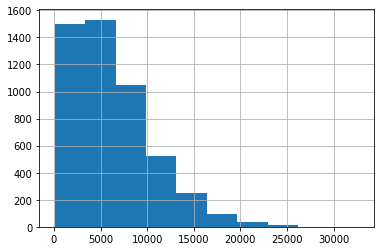

In [12]:
train['Item_Store_Returns'].hist()

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4990 entries, 0 to 4989
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Store_ID             4990 non-null   object 
 1   Item_Weight          4188 non-null   float64
 2   Item_Sugar_Content   4990 non-null   object 
 3   Item_Visibility      4990 non-null   float64
 4   Item_Type            4990 non-null   object 
 5   Item_Price           4990 non-null   float64
 6   Store_Start_Year     4990 non-null   int64  
 7   Store_Size           3540 non-null   object 
 8   Store_Location_Type  4990 non-null   object 
 9   Store_Type           4990 non-null   object 
 10  Item_Store_Returns   4990 non-null   float64
dtypes: float64(4), int64(1), object(6)
memory usage: 429.0+ KB


In [14]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3532 entries, 0 to 3531
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Store_ID             3532 non-null   object 
 1   Item_Weight          2871 non-null   float64
 2   Item_Sugar_Content   3532 non-null   object 
 3   Item_Visibility      3532 non-null   float64
 4   Item_Type            3532 non-null   object 
 5   Item_Price           3532 non-null   float64
 6   Store_Start_Year     3532 non-null   int64  
 7   Store_Size           2573 non-null   object 
 8   Store_Location_Type  3532 non-null   object 
 9   Store_Type           3532 non-null   object 
dtypes: float64(3), int64(1), object(6)
memory usage: 276.1+ KB


### Replacing Missing values

In [15]:
train['Item_Weight'].fillna(train['Item_Weight'].mean(), inplace = True)
test['Item_Weight'].fillna(test['Item_Weight'].mean(), inplace = True)

In [16]:
# train['Store_Size'].value_counts()

In [17]:
# test['Store_Size'].value_counts()

In [18]:
train['Store_Size'].fillna(train['Store_Size'].mode()[0], inplace = True)
test['Store_Size'].fillna(test['Store_Size'].mode()[0], inplace = True)

In [19]:
from datetime import datetime as dt

In [20]:
train['Store_Start_Year'] = (dt.today().year - train['Store_Start_Year']).astype('float')
test['Store_Start_Year'] = (dt.today().year - test['Store_Start_Year']).astype('float')

In [21]:
train['sqrt_Item_Price'] = np.sqrt(train['Item_Price'])
test['sqrt_Item_Price'] = np.sqrt(test['Item_Price'])


train['cross_Item_weight'] = train['Item_Price'] * train['Item_Weight']
test['cross_Item_weight'] = test['Item_Price'] * test['Item_Weight']

train['Cross_Item_visibility_weight'] = train['Item_Price'] * train['Item_Weight'] * train['Item_Visibility']
test['Cross_Item_visibility_weight'] = test['Item_Price'] * test['Item_Weight'] * test['Item_Visibility']

In [22]:
data = train.drop('Item_Store_Returns', axis = 1)
target = train['Item_Store_Returns']

In [23]:
print(data.shape)
print(target.shape)

(4990, 13)
(4990,)


In [24]:
# data['Store_ID'].nunique()

In [25]:
# data['Item_Sugar_Content'].unique()

In [26]:
# data['Item_Type'].unique()

In [27]:
# data['Store_Size'].unique()

In [28]:
# data['Store_Location_Type'].unique()

In [29]:
# data['Store_Type'].unique()

In [30]:
from sklearn.preprocessing import OrdinalEncoder
oe = OrdinalEncoder()

In [31]:
data['Item_Sugar_Content'] = oe.fit_transform(data.Item_Sugar_Content.values.reshape(-1, 1))
test['Item_Sugar_Content'] = oe.fit_transform(test.Item_Sugar_Content.values.reshape(-1, 1))

In [32]:
data['Store_Size'] = oe.fit_transform(data.Store_Size.values.reshape(-1, 1))
test['Store_Size'] = oe.fit_transform(test.Store_Size.values.reshape(-1, 1))

In [33]:
dummy1 = pd.get_dummies(data['Store_ID'],prefix = 'Store_ID' )
dummy2 = pd.get_dummies(test['Store_ID'],prefix = 'Store_ID' )

data = pd.concat([data, dummy1], axis = 1)
test = pd.concat([test, dummy2], axis = 1)

data.drop('Store_ID', axis = 1, inplace = True)
test.drop('Store_ID', axis = 1, inplace = True)

In [34]:
dummy1 = pd.get_dummies(data['Item_Type'],prefix = 'Item_Type' )
dummy2 = pd.get_dummies(test['Item_Type'],prefix = 'Item_Type' )

data = pd.concat([data, dummy1], axis = 1)
test = pd.concat([test, dummy2], axis = 1)

data.drop('Item_Type', axis = 1, inplace = True)
test.drop('Item_Type', axis = 1, inplace = True)

In [35]:
dummy1 = pd.get_dummies(data['Store_Location_Type'],prefix = 'Loc_Type' )
dummy2 = pd.get_dummies(test['Store_Location_Type'],prefix = 'Loc_Type' )

data = pd.concat([data, dummy1], axis = 1)
test = pd.concat([test, dummy2], axis = 1)

data.drop('Store_Location_Type', axis = 1, inplace = True)
test.drop('Store_Location_Type', axis = 1, inplace = True)

In [36]:
dummy1 = pd.get_dummies(data['Store_Type'],prefix = 'Store_Type' )
dummy2 = pd.get_dummies(test['Store_Type'],prefix = 'Store_Type' )

data = pd.concat([data, dummy1], axis = 1)
test = pd.concat([test, dummy2], axis = 1)

data.drop('Store_Type', axis = 1, inplace = True)
test.drop('Store_Type', axis = 1, inplace = True)

In [37]:
print(data.shape)
print(test.shape)

(4990, 42)
(3532, 42)


In [38]:
kf = KFold(n_splits=30)

In [39]:
lgb = LGBMRegressor(num_leaves=200, min_data_in_leaf=3,
                    objective='regression',
                    max_depth=-1,learning_rate=0.05, 
                    boosting_type='gbdt', 
                    feature_fraction=0.60,
                    lambda_l1=1,lambda_l2=1, 
                    metric='rmse', 
                    num_iterations=4000)

xgb = XGBRegressor(n_estimators = 5000, max_depth = 30, 
                     reg_lambda = 80,random_state = 30,
                     learning_rate=0.1, gamma = 1.5)

cat = CatBoostRegressor(iterations = 50, depth = 3, learning_rate = 0.05, loss_function = 'RMSE')

# cat = CatBoostRegressor(n_estimators=5000,max_depth=5,eval_metric='RMSE',reg_lambda=50,random_state=101)

In [40]:
xgb_scores = []
xgb_test_pred = np.zeros(len(test))
xgb_train_pred = np.zeros(len(train))

for fold,(tr_in,te_in) in enumerate(kf.split(data)):
    
    print(f"==================================Fold{fold}=============================================")
    X_train,X_test = data.iloc[tr_in],data.iloc[te_in]
    y_train,y_test = target.iloc[tr_in],target.iloc[te_in]
    
    xgb.fit(X_train,y_train,eval_set = [(X_train,y_train),(X_test,y_test)],
            early_stopping_rounds = 500)
    
    xgb_scores.append(np.sqrt(mse(y_test,xgb.predict(X_test))))
    
    xgb_train_pred += xgb.predict(data)
    xgb_test_pred += xgb.predict(test)

==================================Fold0=============================================
[0]	validation_0-rmse:6982.75000	validation_1-rmse:6803.35791
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 500 rounds.
[1]	validation_0-rmse:6471.67676	validation_1-rmse:6315.89160
[2]	validation_0-rmse:6017.69580	validation_1-rmse:5895.19922
[3]	validation_0-rmse:5618.08887	validation_1-rmse:5535.45850
[4]	validation_0-rmse:5259.57715	validation_1-rmse:5216.09180
[5]	validation_0-rmse:4947.57471	validation_1-rmse:4926.29639
[6]	validation_0-rmse:4667.27588	validation_1-rmse:4673.95898
[7]	validation_0-rmse:4422.09082	validation_1-rmse:4453.97754
[8]	validation_0-rmse:4206.50879	validation_1-rmse:4266.55762
[9]	validation_0-rmse:4018.92432	validation_1-rmse:4104.30566
[10]	validation_0-rmse:3856.40894	validation_1-rmse:3995.60376
[11]	validation_0-rmse:3715.30737	validation_1-rmse:3873.44360
[12]	vali

[126]	validation_0-rmse:1537.01440	validation_1-rmse:3464.20312
[127]	validation_0-rmse:1528.41956	validation_1-rmse:3464.14136
[128]	validation_0-rmse:1519.42615	validation_1-rmse:3465.85230
[129]	validation_0-rmse:1512.26538	validation_1-rmse:3469.91992
[130]	validation_0-rmse:1504.11316	validation_1-rmse:3471.50439
[131]	validation_0-rmse:1498.33496	validation_1-rmse:3472.83496
[132]	validation_0-rmse:1492.98523	validation_1-rmse:3475.48706
[133]	validation_0-rmse:1484.65613	validation_1-rmse:3477.52759
[134]	validation_0-rmse:1476.09680	validation_1-rmse:3477.50244
[135]	validation_0-rmse:1471.25964	validation_1-rmse:3477.54102
[136]	validation_0-rmse:1466.09766	validation_1-rmse:3477.26538
[137]	validation_0-rmse:1459.08435	validation_1-rmse:3476.08106
[138]	validation_0-rmse:1453.56616	validation_1-rmse:3479.36548
[139]	validation_0-rmse:1445.60278	validation_1-rmse:3479.49829
[140]	validation_0-rmse:1437.88086	validation_1-rmse:3481.31201
[141]	validation_0-rmse:1430.09814	valid

[255]	validation_0-rmse:920.63745	validation_1-rmse:3554.99976
[256]	validation_0-rmse:916.15845	validation_1-rmse:3555.60327
[257]	validation_0-rmse:912.48743	validation_1-rmse:3556.16040
[258]	validation_0-rmse:908.99127	validation_1-rmse:3556.58106
[259]	validation_0-rmse:905.68079	validation_1-rmse:3557.15210
[260]	validation_0-rmse:902.07111	validation_1-rmse:3556.82446
[261]	validation_0-rmse:899.72723	validation_1-rmse:3557.14770
[262]	validation_0-rmse:895.88007	validation_1-rmse:3556.95947
[263]	validation_0-rmse:893.69397	validation_1-rmse:3557.46411
[264]	validation_0-rmse:890.81219	validation_1-rmse:3557.84717
[265]	validation_0-rmse:888.72064	validation_1-rmse:3559.47925
[266]	validation_0-rmse:885.43555	validation_1-rmse:3559.26416
[267]	validation_0-rmse:883.90588	validation_1-rmse:3559.54712
[268]	validation_0-rmse:880.97571	validation_1-rmse:3559.45557
[269]	validation_0-rmse:876.80383	validation_1-rmse:3560.36670
[270]	validation_0-rmse:872.81030	validation_1-rmse:356

[386]	validation_0-rmse:615.71942	validation_1-rmse:3593.23706
[387]	validation_0-rmse:613.60583	validation_1-rmse:3592.78418
[388]	validation_0-rmse:611.32758	validation_1-rmse:3593.59399
[389]	validation_0-rmse:609.57593	validation_1-rmse:3594.05615
[390]	validation_0-rmse:607.83240	validation_1-rmse:3594.64746
[391]	validation_0-rmse:605.11859	validation_1-rmse:3594.87207
[392]	validation_0-rmse:602.47803	validation_1-rmse:3594.41455
[393]	validation_0-rmse:600.04517	validation_1-rmse:3594.79712
[394]	validation_0-rmse:598.07117	validation_1-rmse:3594.88086
[395]	validation_0-rmse:596.56964	validation_1-rmse:3595.01269
[396]	validation_0-rmse:594.02649	validation_1-rmse:3596.13477
[397]	validation_0-rmse:591.32745	validation_1-rmse:3595.93091
[398]	validation_0-rmse:589.62109	validation_1-rmse:3596.01733
[399]	validation_0-rmse:587.84381	validation_1-rmse:3595.86865
[400]	validation_0-rmse:586.30841	validation_1-rmse:3596.04346
[401]	validation_0-rmse:584.40869	validation_1-rmse:359

[517]	validation_0-rmse:383.22348	validation_1-rmse:3605.21533
[518]	validation_0-rmse:381.94623	validation_1-rmse:3605.01758
[519]	validation_0-rmse:380.49793	validation_1-rmse:3605.03955
[520]	validation_0-rmse:379.04697	validation_1-rmse:3605.68457
[521]	validation_0-rmse:378.37564	validation_1-rmse:3606.04761
[522]	validation_0-rmse:376.86359	validation_1-rmse:3605.77124
[523]	validation_0-rmse:375.28207	validation_1-rmse:3606.44458
[524]	validation_0-rmse:373.85516	validation_1-rmse:3606.93433
[525]	validation_0-rmse:372.51630	validation_1-rmse:3606.93555
[526]	validation_0-rmse:371.04813	validation_1-rmse:3606.53027
[527]	validation_0-rmse:369.60104	validation_1-rmse:3607.25732
[528]	validation_0-rmse:368.24945	validation_1-rmse:3607.37451
[529]	validation_0-rmse:366.81519	validation_1-rmse:3607.44946
[530]	validation_0-rmse:365.48318	validation_1-rmse:3607.50000
[531]	validation_0-rmse:364.62537	validation_1-rmse:3607.62329
[532]	validation_0-rmse:363.22617	validation_1-rmse:360

[105]	validation_0-rmse:1711.86499	validation_1-rmse:2981.27954
[106]	validation_0-rmse:1704.22852	validation_1-rmse:2980.34937
[107]	validation_0-rmse:1696.56519	validation_1-rmse:2980.86108
[108]	validation_0-rmse:1689.81958	validation_1-rmse:2980.04419
[109]	validation_0-rmse:1682.13635	validation_1-rmse:2978.96216
[110]	validation_0-rmse:1674.28564	validation_1-rmse:2978.64526
[111]	validation_0-rmse:1665.16101	validation_1-rmse:2979.99805
[112]	validation_0-rmse:1657.46692	validation_1-rmse:2983.09668
[113]	validation_0-rmse:1651.42566	validation_1-rmse:2983.47632
[114]	validation_0-rmse:1642.17517	validation_1-rmse:2985.10767
[115]	validation_0-rmse:1634.34180	validation_1-rmse:2986.86231
[116]	validation_0-rmse:1625.12952	validation_1-rmse:2986.34839
[117]	validation_0-rmse:1616.24768	validation_1-rmse:2985.17578
[118]	validation_0-rmse:1607.35669	validation_1-rmse:2983.77417
[119]	validation_0-rmse:1598.85254	validation_1-rmse:2982.63232
[120]	validation_0-rmse:1589.94995	valid

[234]	validation_0-rmse:1027.44421	validation_1-rmse:3065.08911
[235]	validation_0-rmse:1022.61719	validation_1-rmse:3064.67529
[236]	validation_0-rmse:1017.77771	validation_1-rmse:3065.55664
[237]	validation_0-rmse:1013.53992	validation_1-rmse:3066.04736
[238]	validation_0-rmse:1008.72809	validation_1-rmse:3066.85669
[239]	validation_0-rmse:1005.22009	validation_1-rmse:3067.73828
[240]	validation_0-rmse:1000.50690	validation_1-rmse:3066.94800
[241]	validation_0-rmse:995.48743	validation_1-rmse:3067.76294
[242]	validation_0-rmse:990.39624	validation_1-rmse:3067.19751
[243]	validation_0-rmse:987.63977	validation_1-rmse:3067.37451
[244]	validation_0-rmse:984.83264	validation_1-rmse:3068.44238
[245]	validation_0-rmse:979.81628	validation_1-rmse:3068.16650
[246]	validation_0-rmse:974.82880	validation_1-rmse:3067.41943
[247]	validation_0-rmse:970.23932	validation_1-rmse:3069.28467
[248]	validation_0-rmse:965.39764	validation_1-rmse:3068.77368
[249]	validation_0-rmse:961.84332	validation_1-r

[364]	validation_0-rmse:616.72321	validation_1-rmse:3097.06055
[365]	validation_0-rmse:615.06158	validation_1-rmse:3097.59912
[366]	validation_0-rmse:612.41125	validation_1-rmse:3097.49585
[367]	validation_0-rmse:610.64532	validation_1-rmse:3098.08813
[368]	validation_0-rmse:607.71991	validation_1-rmse:3097.65869
[369]	validation_0-rmse:606.11847	validation_1-rmse:3098.35449
[370]	validation_0-rmse:604.62170	validation_1-rmse:3098.35230
[371]	validation_0-rmse:601.99133	validation_1-rmse:3099.50952
[372]	validation_0-rmse:599.88886	validation_1-rmse:3099.59180
[373]	validation_0-rmse:597.83447	validation_1-rmse:3100.27075
[374]	validation_0-rmse:596.31537	validation_1-rmse:3101.48877
[375]	validation_0-rmse:593.85132	validation_1-rmse:3101.80371
[376]	validation_0-rmse:591.97034	validation_1-rmse:3102.79443
[377]	validation_0-rmse:590.12952	validation_1-rmse:3103.54419
[378]	validation_0-rmse:587.43909	validation_1-rmse:3104.57275
[379]	validation_0-rmse:585.26001	validation_1-rmse:310

[495]	validation_0-rmse:380.46005	validation_1-rmse:3123.21558
[496]	validation_0-rmse:379.06018	validation_1-rmse:3123.02856
[497]	validation_0-rmse:377.66199	validation_1-rmse:3122.90063
[498]	validation_0-rmse:376.17545	validation_1-rmse:3122.26294
[499]	validation_0-rmse:374.95117	validation_1-rmse:3122.08252
[500]	validation_0-rmse:373.46323	validation_1-rmse:3121.53931
[501]	validation_0-rmse:371.98294	validation_1-rmse:3121.73853
[502]	validation_0-rmse:370.55884	validation_1-rmse:3121.74609
[503]	validation_0-rmse:369.14963	validation_1-rmse:3121.52783
[504]	validation_0-rmse:367.64813	validation_1-rmse:3121.98144
[505]	validation_0-rmse:366.19717	validation_1-rmse:3121.87646
[506]	validation_0-rmse:364.69910	validation_1-rmse:3121.92749
[507]	validation_0-rmse:363.64276	validation_1-rmse:3121.95508
[508]	validation_0-rmse:362.29407	validation_1-rmse:3122.37671
[509]	validation_0-rmse:361.07275	validation_1-rmse:3122.33716
[510]	validation_0-rmse:359.71570	validation_1-rmse:312

[87]	validation_0-rmse:1892.25977	validation_1-rmse:3112.92603
[88]	validation_0-rmse:1881.87402	validation_1-rmse:3110.59741
[89]	validation_0-rmse:1871.67017	validation_1-rmse:3109.70019
[90]	validation_0-rmse:1861.37195	validation_1-rmse:3111.84424
[91]	validation_0-rmse:1849.18750	validation_1-rmse:3111.43335
[92]	validation_0-rmse:1839.85034	validation_1-rmse:3115.93604
[93]	validation_0-rmse:1830.37769	validation_1-rmse:3120.77344
[94]	validation_0-rmse:1821.83179	validation_1-rmse:3126.21826
[95]	validation_0-rmse:1811.70056	validation_1-rmse:3128.15479
[96]	validation_0-rmse:1801.94641	validation_1-rmse:3125.16089
[97]	validation_0-rmse:1792.28479	validation_1-rmse:3126.05371
[98]	validation_0-rmse:1783.02588	validation_1-rmse:3128.00439
[99]	validation_0-rmse:1774.55957	validation_1-rmse:3130.79468
[100]	validation_0-rmse:1766.41553	validation_1-rmse:3132.85278
[101]	validation_0-rmse:1758.55896	validation_1-rmse:3133.75293
[102]	validation_0-rmse:1748.04785	validation_1-rmse:

[216]	validation_0-rmse:1067.58301	validation_1-rmse:3265.49487
[217]	validation_0-rmse:1063.28955	validation_1-rmse:3265.74414
[218]	validation_0-rmse:1060.88415	validation_1-rmse:3267.19873
[219]	validation_0-rmse:1058.66211	validation_1-rmse:3267.81226
[220]	validation_0-rmse:1055.63379	validation_1-rmse:3268.91113
[221]	validation_0-rmse:1053.28589	validation_1-rmse:3268.49390
[222]	validation_0-rmse:1047.84387	validation_1-rmse:3269.83862
[223]	validation_0-rmse:1043.26184	validation_1-rmse:3270.99292
[224]	validation_0-rmse:1040.27698	validation_1-rmse:3271.23096
[225]	validation_0-rmse:1035.47314	validation_1-rmse:3273.26196
[226]	validation_0-rmse:1032.18506	validation_1-rmse:3274.53101
[227]	validation_0-rmse:1029.71362	validation_1-rmse:3276.22534
[228]	validation_0-rmse:1026.86145	validation_1-rmse:3275.63721
[229]	validation_0-rmse:1024.02832	validation_1-rmse:3276.48706
[230]	validation_0-rmse:1021.63776	validation_1-rmse:3278.10034
[231]	validation_0-rmse:1017.13751	valid

[346]	validation_0-rmse:664.48145	validation_1-rmse:3360.40137
[347]	validation_0-rmse:661.62097	validation_1-rmse:3360.78833
[348]	validation_0-rmse:659.98712	validation_1-rmse:3361.11231
[349]	validation_0-rmse:657.39239	validation_1-rmse:3361.76050
[350]	validation_0-rmse:654.97662	validation_1-rmse:3361.72998
[351]	validation_0-rmse:652.56555	validation_1-rmse:3362.47998
[352]	validation_0-rmse:650.24506	validation_1-rmse:3362.95483
[353]	validation_0-rmse:647.80798	validation_1-rmse:3364.02856
[354]	validation_0-rmse:646.15521	validation_1-rmse:3364.50757
[355]	validation_0-rmse:643.30078	validation_1-rmse:3364.30713
[356]	validation_0-rmse:640.45190	validation_1-rmse:3364.89551
[357]	validation_0-rmse:638.50934	validation_1-rmse:3366.42944
[358]	validation_0-rmse:637.09473	validation_1-rmse:3366.95532
[359]	validation_0-rmse:634.42645	validation_1-rmse:3366.63159
[360]	validation_0-rmse:631.60858	validation_1-rmse:3367.78247
[361]	validation_0-rmse:629.72559	validation_1-rmse:336

[477]	validation_0-rmse:413.81485	validation_1-rmse:3402.74268
[478]	validation_0-rmse:412.37445	validation_1-rmse:3403.35620
[479]	validation_0-rmse:410.75723	validation_1-rmse:3402.98975
[480]	validation_0-rmse:409.19006	validation_1-rmse:3403.21240
[481]	validation_0-rmse:407.49994	validation_1-rmse:3403.29834
[482]	validation_0-rmse:406.18042	validation_1-rmse:3403.85620
[483]	validation_0-rmse:404.52844	validation_1-rmse:3404.14917
[484]	validation_0-rmse:403.08887	validation_1-rmse:3404.50732
[485]	validation_0-rmse:401.80368	validation_1-rmse:3405.49878
[486]	validation_0-rmse:400.32230	validation_1-rmse:3405.47168
[487]	validation_0-rmse:398.79385	validation_1-rmse:3405.91943
[488]	validation_0-rmse:397.19101	validation_1-rmse:3406.38574
[489]	validation_0-rmse:395.82642	validation_1-rmse:3406.39404
[490]	validation_0-rmse:394.34601	validation_1-rmse:3407.00244
[491]	validation_0-rmse:393.11493	validation_1-rmse:3407.68262
[492]	validation_0-rmse:391.86124	validation_1-rmse:340

[64]	validation_0-rmse:2183.42725	validation_1-rmse:3023.17871
[65]	validation_0-rmse:2169.69653	validation_1-rmse:3024.05127
[66]	validation_0-rmse:2156.22461	validation_1-rmse:3024.90723
[67]	validation_0-rmse:2142.58813	validation_1-rmse:3026.57349
[68]	validation_0-rmse:2129.53833	validation_1-rmse:3026.42554
[69]	validation_0-rmse:2117.57031	validation_1-rmse:3025.95972
[70]	validation_0-rmse:2105.69482	validation_1-rmse:3026.92017
[71]	validation_0-rmse:2092.48706	validation_1-rmse:3025.58545
[72]	validation_0-rmse:2081.29688	validation_1-rmse:3025.93018
[73]	validation_0-rmse:2068.72217	validation_1-rmse:3025.02539
[74]	validation_0-rmse:2057.22900	validation_1-rmse:3027.00684
[75]	validation_0-rmse:2044.04114	validation_1-rmse:3029.64648
[76]	validation_0-rmse:2030.57251	validation_1-rmse:3031.42456
[77]	validation_0-rmse:2018.69495	validation_1-rmse:3028.49316
[78]	validation_0-rmse:2006.08374	validation_1-rmse:3030.50659
[79]	validation_0-rmse:1996.04260	validation_1-rmse:303

[193]	validation_0-rmse:1177.97729	validation_1-rmse:3125.69116
[194]	validation_0-rmse:1171.94214	validation_1-rmse:3126.61548
[195]	validation_0-rmse:1165.85486	validation_1-rmse:3126.99048
[196]	validation_0-rmse:1159.94507	validation_1-rmse:3127.11011
[197]	validation_0-rmse:1157.69714	validation_1-rmse:3127.73828
[198]	validation_0-rmse:1154.15772	validation_1-rmse:3129.09106
[199]	validation_0-rmse:1148.58813	validation_1-rmse:3130.73877
[200]	validation_0-rmse:1143.90088	validation_1-rmse:3131.08325
[201]	validation_0-rmse:1141.31616	validation_1-rmse:3131.35840
[202]	validation_0-rmse:1136.71741	validation_1-rmse:3132.05322
[203]	validation_0-rmse:1131.86340	validation_1-rmse:3133.58496
[204]	validation_0-rmse:1126.11523	validation_1-rmse:3135.60962
[205]	validation_0-rmse:1122.51831	validation_1-rmse:3135.66846
[206]	validation_0-rmse:1117.46008	validation_1-rmse:3136.90063
[207]	validation_0-rmse:1111.80750	validation_1-rmse:3138.64429
[208]	validation_0-rmse:1106.30469	valid

[323]	validation_0-rmse:711.93506	validation_1-rmse:3234.55615
[324]	validation_0-rmse:710.19751	validation_1-rmse:3233.64380
[325]	validation_0-rmse:707.31891	validation_1-rmse:3233.82031
[326]	validation_0-rmse:704.51917	validation_1-rmse:3234.06641
[327]	validation_0-rmse:701.78125	validation_1-rmse:3235.36890
[328]	validation_0-rmse:699.64917	validation_1-rmse:3235.96826
[329]	validation_0-rmse:697.63281	validation_1-rmse:3235.81323
[330]	validation_0-rmse:695.80408	validation_1-rmse:3234.99731
[331]	validation_0-rmse:692.68774	validation_1-rmse:3235.50220
[332]	validation_0-rmse:690.97137	validation_1-rmse:3235.92114
[333]	validation_0-rmse:688.33533	validation_1-rmse:3235.70801
[334]	validation_0-rmse:686.26227	validation_1-rmse:3235.08960
[335]	validation_0-rmse:683.25745	validation_1-rmse:3235.47266
[336]	validation_0-rmse:681.13995	validation_1-rmse:3236.21484
[337]	validation_0-rmse:679.33478	validation_1-rmse:3236.67456
[338]	validation_0-rmse:677.54712	validation_1-rmse:323

[454]	validation_0-rmse:451.63705	validation_1-rmse:3275.40918
[455]	validation_0-rmse:449.86499	validation_1-rmse:3275.45776
[456]	validation_0-rmse:448.02167	validation_1-rmse:3275.79248
[457]	validation_0-rmse:446.18082	validation_1-rmse:3275.58032
[458]	validation_0-rmse:444.60626	validation_1-rmse:3275.22339
[459]	validation_0-rmse:442.78159	validation_1-rmse:3275.30859
[460]	validation_0-rmse:441.12506	validation_1-rmse:3275.55640
[461]	validation_0-rmse:439.29504	validation_1-rmse:3275.73901
[462]	validation_0-rmse:437.44812	validation_1-rmse:3276.30762
[463]	validation_0-rmse:435.79459	validation_1-rmse:3275.91235
[464]	validation_0-rmse:434.07596	validation_1-rmse:3275.56616
[465]	validation_0-rmse:432.55414	validation_1-rmse:3275.44116
[466]	validation_0-rmse:430.85312	validation_1-rmse:3275.75586
[467]	validation_0-rmse:429.09302	validation_1-rmse:3275.60278
[468]	validation_0-rmse:427.32355	validation_1-rmse:3276.09351
[469]	validation_0-rmse:425.69907	validation_1-rmse:327

[36]	validation_0-rmse:2636.26245	validation_1-rmse:2928.06274
[37]	validation_0-rmse:2616.17041	validation_1-rmse:2933.14819
[38]	validation_0-rmse:2598.29565	validation_1-rmse:2938.41138
[39]	validation_0-rmse:2579.58960	validation_1-rmse:2938.29150
[40]	validation_0-rmse:2561.18408	validation_1-rmse:2938.29810
[41]	validation_0-rmse:2542.60986	validation_1-rmse:2939.79517
[42]	validation_0-rmse:2525.52319	validation_1-rmse:2941.81494
[43]	validation_0-rmse:2508.76514	validation_1-rmse:2942.92700
[44]	validation_0-rmse:2491.36011	validation_1-rmse:2944.01636
[45]	validation_0-rmse:2471.94458	validation_1-rmse:2939.79370
[46]	validation_0-rmse:2454.77979	validation_1-rmse:2940.62012
[47]	validation_0-rmse:2438.84961	validation_1-rmse:2944.10352
[48]	validation_0-rmse:2421.25073	validation_1-rmse:2946.81055
[49]	validation_0-rmse:2403.80103	validation_1-rmse:2947.77026
[50]	validation_0-rmse:2388.24048	validation_1-rmse:2948.16772
[51]	validation_0-rmse:2370.66968	validation_1-rmse:294

[166]	validation_0-rmse:1296.42749	validation_1-rmse:3062.25269
[167]	validation_0-rmse:1294.22571	validation_1-rmse:3062.46020
[168]	validation_0-rmse:1288.73828	validation_1-rmse:3061.85791
[169]	validation_0-rmse:1282.58643	validation_1-rmse:3061.26074
[170]	validation_0-rmse:1277.77136	validation_1-rmse:3061.32031
[171]	validation_0-rmse:1273.56335	validation_1-rmse:3063.36231
[172]	validation_0-rmse:1267.48169	validation_1-rmse:3065.06836
[173]	validation_0-rmse:1263.64111	validation_1-rmse:3066.48291
[174]	validation_0-rmse:1259.99695	validation_1-rmse:3066.29565
[175]	validation_0-rmse:1253.88367	validation_1-rmse:3065.83423
[176]	validation_0-rmse:1251.16589	validation_1-rmse:3067.27808
[177]	validation_0-rmse:1247.19421	validation_1-rmse:3066.26294
[178]	validation_0-rmse:1243.07044	validation_1-rmse:3068.31787
[179]	validation_0-rmse:1238.85754	validation_1-rmse:3067.06030
[180]	validation_0-rmse:1235.88147	validation_1-rmse:3067.73682
[181]	validation_0-rmse:1231.41479	valid

[295]	validation_0-rmse:793.94397	validation_1-rmse:3089.44434
[296]	validation_0-rmse:789.95477	validation_1-rmse:3090.05933
[297]	validation_0-rmse:785.94550	validation_1-rmse:3091.15210
[298]	validation_0-rmse:783.48352	validation_1-rmse:3090.95239
[299]	validation_0-rmse:781.15192	validation_1-rmse:3091.20117
[300]	validation_0-rmse:777.80444	validation_1-rmse:3091.45776
[301]	validation_0-rmse:775.99896	validation_1-rmse:3091.31299
[302]	validation_0-rmse:773.66425	validation_1-rmse:3091.58691
[303]	validation_0-rmse:771.53278	validation_1-rmse:3092.53589
[304]	validation_0-rmse:768.14600	validation_1-rmse:3092.53320
[305]	validation_0-rmse:764.76361	validation_1-rmse:3093.52026
[306]	validation_0-rmse:761.69202	validation_1-rmse:3092.87329
[307]	validation_0-rmse:759.07684	validation_1-rmse:3093.21899
[308]	validation_0-rmse:756.76746	validation_1-rmse:3093.52686
[309]	validation_0-rmse:754.26324	validation_1-rmse:3094.00537
[310]	validation_0-rmse:752.27075	validation_1-rmse:309

[426]	validation_0-rmse:509.37158	validation_1-rmse:3103.40210
[427]	validation_0-rmse:507.15680	validation_1-rmse:3103.99658
[428]	validation_0-rmse:504.90720	validation_1-rmse:3104.00244
[429]	validation_0-rmse:502.73471	validation_1-rmse:3104.06885
[430]	validation_0-rmse:500.53116	validation_1-rmse:3103.70239
[431]	validation_0-rmse:498.45435	validation_1-rmse:3103.97266
[432]	validation_0-rmse:496.92191	validation_1-rmse:3104.25439
[433]	validation_0-rmse:494.82382	validation_1-rmse:3104.15112
[434]	validation_0-rmse:492.95596	validation_1-rmse:3104.66675
[435]	validation_0-rmse:490.92734	validation_1-rmse:3104.54907
[436]	validation_0-rmse:489.20160	validation_1-rmse:3104.64990
[437]	validation_0-rmse:487.16797	validation_1-rmse:3104.82983
[438]	validation_0-rmse:485.16480	validation_1-rmse:3104.98901
[439]	validation_0-rmse:483.82938	validation_1-rmse:3104.97266
[440]	validation_0-rmse:482.05994	validation_1-rmse:3105.20166
[441]	validation_0-rmse:480.01065	validation_1-rmse:310

[17]	validation_0-rmse:3197.11084	validation_1-rmse:2814.79907
[18]	validation_0-rmse:3146.48560	validation_1-rmse:2768.23218
[19]	validation_0-rmse:3101.57178	validation_1-rmse:2730.92163
[20]	validation_0-rmse:3058.92895	validation_1-rmse:2701.16626
[21]	validation_0-rmse:3018.23267	validation_1-rmse:2664.07715
[22]	validation_0-rmse:2981.94751	validation_1-rmse:2639.44531
[23]	validation_0-rmse:2950.24854	validation_1-rmse:2618.51709
[24]	validation_0-rmse:2919.57422	validation_1-rmse:2590.39575
[25]	validation_0-rmse:2892.81982	validation_1-rmse:2574.70972
[26]	validation_0-rmse:2867.81274	validation_1-rmse:2562.33862
[27]	validation_0-rmse:2844.05786	validation_1-rmse:2562.94922
[28]	validation_0-rmse:2819.90234	validation_1-rmse:2559.33106
[29]	validation_0-rmse:2796.52979	validation_1-rmse:2545.48120
[30]	validation_0-rmse:2772.51489	validation_1-rmse:2549.40698
[31]	validation_0-rmse:2752.27612	validation_1-rmse:2537.95557
[32]	validation_0-rmse:2731.62476	validation_1-rmse:253

[147]	validation_0-rmse:1392.98791	validation_1-rmse:2562.42773
[148]	validation_0-rmse:1387.63928	validation_1-rmse:2562.47314
[149]	validation_0-rmse:1383.90173	validation_1-rmse:2561.07446
[150]	validation_0-rmse:1377.54297	validation_1-rmse:2562.51611
[151]	validation_0-rmse:1371.53650	validation_1-rmse:2560.86450
[152]	validation_0-rmse:1363.45813	validation_1-rmse:2561.93677
[153]	validation_0-rmse:1356.40747	validation_1-rmse:2567.14990
[154]	validation_0-rmse:1349.58521	validation_1-rmse:2567.18970
[155]	validation_0-rmse:1342.48865	validation_1-rmse:2568.29370
[156]	validation_0-rmse:1335.58972	validation_1-rmse:2573.08936
[157]	validation_0-rmse:1329.75562	validation_1-rmse:2574.20752
[158]	validation_0-rmse:1323.27588	validation_1-rmse:2573.59570
[159]	validation_0-rmse:1317.86938	validation_1-rmse:2575.89087
[160]	validation_0-rmse:1311.95642	validation_1-rmse:2579.67114
[161]	validation_0-rmse:1306.85999	validation_1-rmse:2580.47241
[162]	validation_0-rmse:1303.60376	valid

[276]	validation_0-rmse:846.13318	validation_1-rmse:2610.83545
[277]	validation_0-rmse:842.50653	validation_1-rmse:2611.51245
[278]	validation_0-rmse:840.08099	validation_1-rmse:2611.64453
[279]	validation_0-rmse:837.82623	validation_1-rmse:2611.69653
[280]	validation_0-rmse:834.82733	validation_1-rmse:2611.44434
[281]	validation_0-rmse:832.58295	validation_1-rmse:2610.92114
[282]	validation_0-rmse:829.86639	validation_1-rmse:2610.92188
[283]	validation_0-rmse:825.94891	validation_1-rmse:2611.36645
[284]	validation_0-rmse:822.00781	validation_1-rmse:2612.12988
[285]	validation_0-rmse:819.28332	validation_1-rmse:2613.18140
[286]	validation_0-rmse:816.26324	validation_1-rmse:2614.61792
[287]	validation_0-rmse:814.00812	validation_1-rmse:2616.04736
[288]	validation_0-rmse:811.95190	validation_1-rmse:2617.22998
[289]	validation_0-rmse:808.58734	validation_1-rmse:2618.08154
[290]	validation_0-rmse:805.39880	validation_1-rmse:2618.97437
[291]	validation_0-rmse:802.59027	validation_1-rmse:261

[407]	validation_0-rmse:518.75848	validation_1-rmse:2653.57568
[408]	validation_0-rmse:516.50940	validation_1-rmse:2653.77441
[409]	validation_0-rmse:514.20520	validation_1-rmse:2653.95093
[410]	validation_0-rmse:511.83514	validation_1-rmse:2655.31030
[411]	validation_0-rmse:510.36185	validation_1-rmse:2655.32153
[412]	validation_0-rmse:508.31009	validation_1-rmse:2655.21924
[413]	validation_0-rmse:506.16791	validation_1-rmse:2654.99390
[414]	validation_0-rmse:504.39127	validation_1-rmse:2655.19336
[415]	validation_0-rmse:502.22644	validation_1-rmse:2655.36426
[416]	validation_0-rmse:500.12552	validation_1-rmse:2655.13379
[417]	validation_0-rmse:498.08768	validation_1-rmse:2654.86084
[418]	validation_0-rmse:495.93503	validation_1-rmse:2654.42993
[419]	validation_0-rmse:494.22452	validation_1-rmse:2654.07715
[420]	validation_0-rmse:492.17111	validation_1-rmse:2653.69360
[421]	validation_0-rmse:490.39002	validation_1-rmse:2654.16699
[422]	validation_0-rmse:488.50046	validation_1-rmse:265

[538]	validation_0-rmse:322.77567	validation_1-rmse:2679.75952
[539]	validation_0-rmse:321.70682	validation_1-rmse:2679.62280
[540]	validation_0-rmse:320.53473	validation_1-rmse:2680.04394
[541]	validation_0-rmse:319.51004	validation_1-rmse:2680.25635
[542]	validation_0-rmse:318.27209	validation_1-rmse:2679.98047
[543]	validation_0-rmse:317.05542	validation_1-rmse:2679.84180
[544]	validation_0-rmse:316.03903	validation_1-rmse:2679.69458
[545]	validation_0-rmse:314.93967	validation_1-rmse:2679.53101
[546]	validation_0-rmse:313.75449	validation_1-rmse:2679.61963
[547]	validation_0-rmse:312.65338	validation_1-rmse:2679.56494
[548]	validation_0-rmse:311.41980	validation_1-rmse:2679.46875
[549]	validation_0-rmse:310.23257	validation_1-rmse:2680.09546
[550]	validation_0-rmse:309.00632	validation_1-rmse:2680.45898
[551]	validation_0-rmse:307.74918	validation_1-rmse:2680.63013
[552]	validation_0-rmse:306.58624	validation_1-rmse:2680.52441
[553]	validation_0-rmse:305.46051	validation_1-rmse:268

[102]	validation_0-rmse:1731.30518	validation_1-rmse:3035.32544
[103]	validation_0-rmse:1721.84973	validation_1-rmse:3039.95850
[104]	validation_0-rmse:1713.06421	validation_1-rmse:3043.98828
[105]	validation_0-rmse:1703.35510	validation_1-rmse:3043.51074
[106]	validation_0-rmse:1693.42725	validation_1-rmse:3045.95825
[107]	validation_0-rmse:1684.47266	validation_1-rmse:3047.32544
[108]	validation_0-rmse:1677.55688	validation_1-rmse:3046.70117
[109]	validation_0-rmse:1667.98669	validation_1-rmse:3051.46533
[110]	validation_0-rmse:1657.66834	validation_1-rmse:3050.22168
[111]	validation_0-rmse:1651.43372	validation_1-rmse:3050.44556
[112]	validation_0-rmse:1643.11719	validation_1-rmse:3054.00488
[113]	validation_0-rmse:1635.30127	validation_1-rmse:3056.39941
[114]	validation_0-rmse:1628.87292	validation_1-rmse:3058.27197
[115]	validation_0-rmse:1619.38721	validation_1-rmse:3061.51343
[116]	validation_0-rmse:1613.34009	validation_1-rmse:3062.21973
[117]	validation_0-rmse:1605.37048	valid

[231]	validation_0-rmse:972.31122	validation_1-rmse:3173.07349
[232]	validation_0-rmse:968.45203	validation_1-rmse:3174.10767
[233]	validation_0-rmse:963.74756	validation_1-rmse:3174.99219
[234]	validation_0-rmse:958.86536	validation_1-rmse:3177.81226
[235]	validation_0-rmse:955.22125	validation_1-rmse:3178.51636
[236]	validation_0-rmse:951.35162	validation_1-rmse:3179.04541
[237]	validation_0-rmse:946.61371	validation_1-rmse:3180.43823
[238]	validation_0-rmse:943.70789	validation_1-rmse:3181.56860
[239]	validation_0-rmse:939.82886	validation_1-rmse:3183.31934
[240]	validation_0-rmse:935.33215	validation_1-rmse:3183.30640
[241]	validation_0-rmse:930.60553	validation_1-rmse:3184.24438
[242]	validation_0-rmse:927.25928	validation_1-rmse:3184.84009
[243]	validation_0-rmse:923.17755	validation_1-rmse:3184.65283
[244]	validation_0-rmse:920.06464	validation_1-rmse:3184.90308
[245]	validation_0-rmse:918.11627	validation_1-rmse:3184.94385
[246]	validation_0-rmse:915.66388	validation_1-rmse:318

[362]	validation_0-rmse:619.88959	validation_1-rmse:3232.84888
[363]	validation_0-rmse:617.80658	validation_1-rmse:3233.50806
[364]	validation_0-rmse:615.30023	validation_1-rmse:3234.05103
[365]	validation_0-rmse:613.11340	validation_1-rmse:3234.15698
[366]	validation_0-rmse:610.59821	validation_1-rmse:3233.80127
[367]	validation_0-rmse:608.27008	validation_1-rmse:3233.38672
[368]	validation_0-rmse:605.97119	validation_1-rmse:3233.50049
[369]	validation_0-rmse:604.11346	validation_1-rmse:3233.81543
[370]	validation_0-rmse:602.61011	validation_1-rmse:3233.90234
[371]	validation_0-rmse:600.20239	validation_1-rmse:3234.81104
[372]	validation_0-rmse:598.56970	validation_1-rmse:3235.35230
[373]	validation_0-rmse:596.55963	validation_1-rmse:3234.86938
[374]	validation_0-rmse:593.98279	validation_1-rmse:3235.63769
[375]	validation_0-rmse:591.70282	validation_1-rmse:3235.19605
[376]	validation_0-rmse:589.80487	validation_1-rmse:3235.43726
[377]	validation_0-rmse:588.28284	validation_1-rmse:323

[493]	validation_0-rmse:390.51172	validation_1-rmse:3255.09644
[494]	validation_0-rmse:388.95459	validation_1-rmse:3255.22510
[495]	validation_0-rmse:387.35309	validation_1-rmse:3255.46851
[496]	validation_0-rmse:385.80692	validation_1-rmse:3256.27979
[497]	validation_0-rmse:384.25699	validation_1-rmse:3256.24731
[498]	validation_0-rmse:382.69455	validation_1-rmse:3256.33984
[499]	validation_0-rmse:381.24594	validation_1-rmse:3256.49878
[500]	validation_0-rmse:379.79355	validation_1-rmse:3256.57251
[501]	validation_0-rmse:378.28204	validation_1-rmse:3256.21631
[502]	validation_0-rmse:377.02133	validation_1-rmse:3256.07324
[503]	validation_0-rmse:375.63492	validation_1-rmse:3255.97827
[504]	validation_0-rmse:374.14383	validation_1-rmse:3255.72412
[505]	validation_0-rmse:372.69879	validation_1-rmse:3255.88477
[506]	validation_0-rmse:371.26556	validation_1-rmse:3256.28027
[507]	validation_0-rmse:369.90805	validation_1-rmse:3256.35547
[508]	validation_0-rmse:368.55280	validation_1-rmse:325

[62]	validation_0-rmse:2197.41919	validation_1-rmse:3129.83106
[63]	validation_0-rmse:2183.03271	validation_1-rmse:3130.28882
[64]	validation_0-rmse:2168.08936	validation_1-rmse:3130.90015
[65]	validation_0-rmse:2154.03076	validation_1-rmse:3130.65503
[66]	validation_0-rmse:2140.66821	validation_1-rmse:3131.65381
[67]	validation_0-rmse:2126.56836	validation_1-rmse:3133.60059
[68]	validation_0-rmse:2113.60938	validation_1-rmse:3132.76514
[69]	validation_0-rmse:2099.93555	validation_1-rmse:3136.19775
[70]	validation_0-rmse:2086.67847	validation_1-rmse:3135.88477
[71]	validation_0-rmse:2073.89429	validation_1-rmse:3136.19360
[72]	validation_0-rmse:2060.98315	validation_1-rmse:3138.78149
[73]	validation_0-rmse:2047.44898	validation_1-rmse:3139.00977
[74]	validation_0-rmse:2033.44885	validation_1-rmse:3141.12378
[75]	validation_0-rmse:2021.74841	validation_1-rmse:3140.05615
[76]	validation_0-rmse:2008.14124	validation_1-rmse:3141.22632
[77]	validation_0-rmse:1995.29358	validation_1-rmse:314

[191]	validation_0-rmse:1144.39429	validation_1-rmse:3233.99365
[192]	validation_0-rmse:1141.73035	validation_1-rmse:3234.90625
[193]	validation_0-rmse:1137.85132	validation_1-rmse:3234.87891
[194]	validation_0-rmse:1132.95312	validation_1-rmse:3235.98608
[195]	validation_0-rmse:1129.58337	validation_1-rmse:3237.96387
[196]	validation_0-rmse:1125.85779	validation_1-rmse:3237.91626
[197]	validation_0-rmse:1122.57532	validation_1-rmse:3239.14795
[198]	validation_0-rmse:1117.40857	validation_1-rmse:3239.28931
[199]	validation_0-rmse:1113.94544	validation_1-rmse:3238.43530
[200]	validation_0-rmse:1109.42407	validation_1-rmse:3239.54932
[201]	validation_0-rmse:1105.83569	validation_1-rmse:3241.88745
[202]	validation_0-rmse:1102.67493	validation_1-rmse:3243.48584
[203]	validation_0-rmse:1097.60107	validation_1-rmse:3243.78809
[204]	validation_0-rmse:1092.14392	validation_1-rmse:3246.02734
[205]	validation_0-rmse:1086.51599	validation_1-rmse:3247.63867
[206]	validation_0-rmse:1081.29114	valid

[321]	validation_0-rmse:695.12311	validation_1-rmse:3287.60840
[322]	validation_0-rmse:692.10175	validation_1-rmse:3287.91846
[323]	validation_0-rmse:690.29712	validation_1-rmse:3288.11890
[324]	validation_0-rmse:688.02081	validation_1-rmse:3287.94409
[325]	validation_0-rmse:685.37408	validation_1-rmse:3287.68628
[326]	validation_0-rmse:682.17963	validation_1-rmse:3288.28320
[327]	validation_0-rmse:679.92566	validation_1-rmse:3288.27563
[328]	validation_0-rmse:678.31470	validation_1-rmse:3288.23120
[329]	validation_0-rmse:676.48499	validation_1-rmse:3288.48120
[330]	validation_0-rmse:674.73218	validation_1-rmse:3288.74512
[331]	validation_0-rmse:673.13855	validation_1-rmse:3288.96558
[332]	validation_0-rmse:671.22137	validation_1-rmse:3289.33081
[333]	validation_0-rmse:668.62018	validation_1-rmse:3289.92676
[334]	validation_0-rmse:665.84839	validation_1-rmse:3290.51880
[335]	validation_0-rmse:663.59467	validation_1-rmse:3290.94189
[336]	validation_0-rmse:661.51178	validation_1-rmse:329

[452]	validation_0-rmse:443.46820	validation_1-rmse:3306.71020
[453]	validation_0-rmse:441.73575	validation_1-rmse:3307.15796
[454]	validation_0-rmse:440.27628	validation_1-rmse:3307.77148
[455]	validation_0-rmse:438.38516	validation_1-rmse:3308.23340
[456]	validation_0-rmse:437.12616	validation_1-rmse:3308.63843
[457]	validation_0-rmse:435.34088	validation_1-rmse:3308.41553
[458]	validation_0-rmse:433.64398	validation_1-rmse:3308.64380
[459]	validation_0-rmse:432.06540	validation_1-rmse:3309.01880
[460]	validation_0-rmse:430.28970	validation_1-rmse:3308.51856
[461]	validation_0-rmse:428.87482	validation_1-rmse:3308.86401
[462]	validation_0-rmse:427.12482	validation_1-rmse:3308.52808
[463]	validation_0-rmse:425.44400	validation_1-rmse:3308.32861
[464]	validation_0-rmse:423.79706	validation_1-rmse:3308.39356
[465]	validation_0-rmse:422.67218	validation_1-rmse:3308.46753
[466]	validation_0-rmse:421.17624	validation_1-rmse:3308.75195
[467]	validation_0-rmse:419.40973	validation_1-rmse:330

[36]	validation_0-rmse:2649.78809	validation_1-rmse:2641.44043
[37]	validation_0-rmse:2632.41113	validation_1-rmse:2638.74145
[38]	validation_0-rmse:2613.78662	validation_1-rmse:2633.63452
[39]	validation_0-rmse:2595.27954	validation_1-rmse:2640.91992
[40]	validation_0-rmse:2575.46729	validation_1-rmse:2636.77075
[41]	validation_0-rmse:2556.84717	validation_1-rmse:2630.99243
[42]	validation_0-rmse:2538.59863	validation_1-rmse:2629.80542
[43]	validation_0-rmse:2521.99145	validation_1-rmse:2628.27295
[44]	validation_0-rmse:2503.57275	validation_1-rmse:2625.96997
[45]	validation_0-rmse:2486.30420	validation_1-rmse:2626.90747
[46]	validation_0-rmse:2469.13428	validation_1-rmse:2632.98169
[47]	validation_0-rmse:2452.03149	validation_1-rmse:2636.24634
[48]	validation_0-rmse:2435.23950	validation_1-rmse:2639.44214
[49]	validation_0-rmse:2419.37573	validation_1-rmse:2640.91821
[50]	validation_0-rmse:2402.67432	validation_1-rmse:2644.55298
[51]	validation_0-rmse:2387.48364	validation_1-rmse:264

[166]	validation_0-rmse:1357.31274	validation_1-rmse:2740.40405
[167]	validation_0-rmse:1354.05811	validation_1-rmse:2741.99878
[168]	validation_0-rmse:1349.39307	validation_1-rmse:2742.41602
[169]	validation_0-rmse:1341.99402	validation_1-rmse:2744.02051
[170]	validation_0-rmse:1334.67810	validation_1-rmse:2743.79785
[171]	validation_0-rmse:1332.10242	validation_1-rmse:2744.51367
[172]	validation_0-rmse:1326.49206	validation_1-rmse:2744.45923
[173]	validation_0-rmse:1321.21790	validation_1-rmse:2745.01856
[174]	validation_0-rmse:1316.28601	validation_1-rmse:2743.07080
[175]	validation_0-rmse:1312.32446	validation_1-rmse:2744.51953
[176]	validation_0-rmse:1305.79016	validation_1-rmse:2744.54321
[177]	validation_0-rmse:1299.20960	validation_1-rmse:2745.44214
[178]	validation_0-rmse:1293.00403	validation_1-rmse:2749.77417
[179]	validation_0-rmse:1286.19629	validation_1-rmse:2750.09937
[180]	validation_0-rmse:1281.71533	validation_1-rmse:2750.30591
[181]	validation_0-rmse:1278.38220	valid

[295]	validation_0-rmse:821.85272	validation_1-rmse:2795.81836
[296]	validation_0-rmse:819.45227	validation_1-rmse:2795.71558
[297]	validation_0-rmse:817.28876	validation_1-rmse:2795.23389
[298]	validation_0-rmse:813.29028	validation_1-rmse:2795.58984
[299]	validation_0-rmse:809.41504	validation_1-rmse:2795.74805
[300]	validation_0-rmse:806.34979	validation_1-rmse:2797.06274
[301]	validation_0-rmse:802.64429	validation_1-rmse:2797.59985
[302]	validation_0-rmse:800.04419	validation_1-rmse:2798.26758
[303]	validation_0-rmse:796.36395	validation_1-rmse:2798.80493
[304]	validation_0-rmse:793.01343	validation_1-rmse:2798.97070
[305]	validation_0-rmse:789.35761	validation_1-rmse:2799.25488
[306]	validation_0-rmse:786.25085	validation_1-rmse:2800.46973
[307]	validation_0-rmse:782.74200	validation_1-rmse:2800.83594
[308]	validation_0-rmse:779.17694	validation_1-rmse:2800.37573
[309]	validation_0-rmse:775.79901	validation_1-rmse:2801.73511
[310]	validation_0-rmse:772.76874	validation_1-rmse:280

[426]	validation_0-rmse:507.20358	validation_1-rmse:2816.97021
[427]	validation_0-rmse:505.66037	validation_1-rmse:2816.72827
[428]	validation_0-rmse:503.81097	validation_1-rmse:2816.59155
[429]	validation_0-rmse:502.56641	validation_1-rmse:2816.56519
[430]	validation_0-rmse:500.50012	validation_1-rmse:2817.76880
[431]	validation_0-rmse:498.42645	validation_1-rmse:2818.24731
[432]	validation_0-rmse:496.29184	validation_1-rmse:2818.22070
[433]	validation_0-rmse:494.30902	validation_1-rmse:2818.43237
[434]	validation_0-rmse:492.39011	validation_1-rmse:2819.14868
[435]	validation_0-rmse:490.22574	validation_1-rmse:2819.62793
[436]	validation_0-rmse:488.02292	validation_1-rmse:2819.01392
[437]	validation_0-rmse:485.87784	validation_1-rmse:2818.98413
[438]	validation_0-rmse:484.41388	validation_1-rmse:2819.33789
[439]	validation_0-rmse:482.39871	validation_1-rmse:2819.84619
[440]	validation_0-rmse:480.34421	validation_1-rmse:2820.01416
[441]	validation_0-rmse:478.39456	validation_1-rmse:282

[6]	validation_0-rmse:4658.28467	validation_1-rmse:5074.43897
[7]	validation_0-rmse:4412.75049	validation_1-rmse:4832.23779
[8]	validation_0-rmse:4198.90772	validation_1-rmse:4608.37353
[9]	validation_0-rmse:4011.75562	validation_1-rmse:4424.71484
[10]	validation_0-rmse:3849.43652	validation_1-rmse:4262.57568
[11]	validation_0-rmse:3708.54175	validation_1-rmse:4129.85498
[12]	validation_0-rmse:3586.97437	validation_1-rmse:4003.08569
[13]	validation_0-rmse:3479.89111	validation_1-rmse:3905.37402
[14]	validation_0-rmse:3387.30664	validation_1-rmse:3821.33228
[15]	validation_0-rmse:3307.38257	validation_1-rmse:3747.21704
[16]	validation_0-rmse:3237.84399	validation_1-rmse:3684.11133
[17]	validation_0-rmse:3175.96045	validation_1-rmse:3633.44067
[18]	validation_0-rmse:3121.45117	validation_1-rmse:3595.98047
[19]	validation_0-rmse:3075.55591	validation_1-rmse:3552.02563
[20]	validation_0-rmse:3031.14770	validation_1-rmse:3516.22730
[21]	validation_0-rmse:2992.25269	validation_1-rmse:3484.78

[136]	validation_0-rmse:1484.24866	validation_1-rmse:3411.95264
[137]	validation_0-rmse:1478.09460	validation_1-rmse:3412.65161
[138]	validation_0-rmse:1470.26245	validation_1-rmse:3413.13721
[139]	validation_0-rmse:1465.33618	validation_1-rmse:3412.66602
[140]	validation_0-rmse:1456.92481	validation_1-rmse:3413.74048
[141]	validation_0-rmse:1450.79480	validation_1-rmse:3413.56494
[142]	validation_0-rmse:1445.74280	validation_1-rmse:3416.07275
[143]	validation_0-rmse:1438.55908	validation_1-rmse:3415.49927
[144]	validation_0-rmse:1430.18713	validation_1-rmse:3414.91382
[145]	validation_0-rmse:1427.00195	validation_1-rmse:3414.56323
[146]	validation_0-rmse:1420.74121	validation_1-rmse:3416.23853
[147]	validation_0-rmse:1415.43262	validation_1-rmse:3418.48462
[148]	validation_0-rmse:1410.86792	validation_1-rmse:3418.46436
[149]	validation_0-rmse:1407.44959	validation_1-rmse:3418.52417
[150]	validation_0-rmse:1402.65100	validation_1-rmse:3418.79053
[151]	validation_0-rmse:1398.00098	valid

[265]	validation_0-rmse:870.31012	validation_1-rmse:3478.27026
[266]	validation_0-rmse:866.47492	validation_1-rmse:3478.01245
[267]	validation_0-rmse:862.63593	validation_1-rmse:3478.48608
[268]	validation_0-rmse:858.71435	validation_1-rmse:3478.76758
[269]	validation_0-rmse:854.56018	validation_1-rmse:3479.71558
[270]	validation_0-rmse:850.57794	validation_1-rmse:3480.02637
[271]	validation_0-rmse:847.49652	validation_1-rmse:3480.19287
[272]	validation_0-rmse:843.51337	validation_1-rmse:3480.07739
[273]	validation_0-rmse:839.37329	validation_1-rmse:3480.45117
[274]	validation_0-rmse:836.09723	validation_1-rmse:3480.05371
[275]	validation_0-rmse:832.89783	validation_1-rmse:3479.55762
[276]	validation_0-rmse:829.99603	validation_1-rmse:3480.13355
[277]	validation_0-rmse:827.09357	validation_1-rmse:3480.26709
[278]	validation_0-rmse:824.02881	validation_1-rmse:3480.39233
[279]	validation_0-rmse:821.65643	validation_1-rmse:3480.95581
[280]	validation_0-rmse:818.38733	validation_1-rmse:348

[396]	validation_0-rmse:537.91852	validation_1-rmse:3518.03980
[397]	validation_0-rmse:536.08624	validation_1-rmse:3518.32251
[398]	validation_0-rmse:533.75049	validation_1-rmse:3517.79102
[399]	validation_0-rmse:531.68262	validation_1-rmse:3518.35059
[400]	validation_0-rmse:529.83929	validation_1-rmse:3518.63208
[401]	validation_0-rmse:528.36975	validation_1-rmse:3519.29272
[402]	validation_0-rmse:526.01679	validation_1-rmse:3519.64575
[403]	validation_0-rmse:523.69458	validation_1-rmse:3520.07837
[404]	validation_0-rmse:521.41077	validation_1-rmse:3520.73901
[405]	validation_0-rmse:519.20074	validation_1-rmse:3520.29126
[406]	validation_0-rmse:517.22125	validation_1-rmse:3521.23731
[407]	validation_0-rmse:515.06708	validation_1-rmse:3521.22485
[408]	validation_0-rmse:512.83496	validation_1-rmse:3521.76807
[409]	validation_0-rmse:510.58328	validation_1-rmse:3522.30957
[410]	validation_0-rmse:508.79727	validation_1-rmse:3522.52100
[411]	validation_0-rmse:507.48172	validation_1-rmse:352

[527]	validation_0-rmse:334.23013	validation_1-rmse:3548.63428
[528]	validation_0-rmse:333.07526	validation_1-rmse:3548.83106
[529]	validation_0-rmse:331.76205	validation_1-rmse:3548.71558
[530]	validation_0-rmse:330.66113	validation_1-rmse:3548.68945
[531]	validation_0-rmse:329.38721	validation_1-rmse:3548.99512
[532]	validation_0-rmse:328.14429	validation_1-rmse:3549.18042
[533]	validation_0-rmse:326.85931	validation_1-rmse:3549.88110
[534]	validation_0-rmse:325.62213	validation_1-rmse:3549.88355
[535]	validation_0-rmse:324.32162	validation_1-rmse:3550.30347
[536]	validation_0-rmse:323.05530	validation_1-rmse:3550.64478
[537]	validation_0-rmse:321.83179	validation_1-rmse:3551.03906
[538]	validation_0-rmse:320.65762	validation_1-rmse:3551.33716
[539]	validation_0-rmse:319.43295	validation_1-rmse:3551.34302
[540]	validation_0-rmse:318.23236	validation_1-rmse:3551.75855
[541]	validation_0-rmse:317.06470	validation_1-rmse:3552.00122
[542]	validation_0-rmse:315.90134	validation_1-rmse:355

[109]	validation_0-rmse:1668.38086	validation_1-rmse:3570.72510
[110]	validation_0-rmse:1661.88769	validation_1-rmse:3571.25122
[111]	validation_0-rmse:1655.53479	validation_1-rmse:3573.17627
[112]	validation_0-rmse:1645.50610	validation_1-rmse:3573.53345
[113]	validation_0-rmse:1638.69946	validation_1-rmse:3571.39209
[114]	validation_0-rmse:1629.34875	validation_1-rmse:3573.78638
[115]	validation_0-rmse:1622.55981	validation_1-rmse:3577.46045
[116]	validation_0-rmse:1613.53906	validation_1-rmse:3581.21484
[117]	validation_0-rmse:1605.95923	validation_1-rmse:3585.50317
[118]	validation_0-rmse:1597.09619	validation_1-rmse:3590.06274
[119]	validation_0-rmse:1589.56250	validation_1-rmse:3593.34204
[120]	validation_0-rmse:1580.90125	validation_1-rmse:3594.95679
[121]	validation_0-rmse:1572.26770	validation_1-rmse:3595.79736
[122]	validation_0-rmse:1563.23230	validation_1-rmse:3599.70093
[123]	validation_0-rmse:1558.91223	validation_1-rmse:3601.32349
[124]	validation_0-rmse:1550.51819	valid

[238]	validation_0-rmse:995.26282	validation_1-rmse:3695.42505
[239]	validation_0-rmse:991.31598	validation_1-rmse:3693.49390
[240]	validation_0-rmse:986.47382	validation_1-rmse:3693.21167
[241]	validation_0-rmse:982.02948	validation_1-rmse:3693.71948
[242]	validation_0-rmse:977.41766	validation_1-rmse:3694.25195
[243]	validation_0-rmse:972.83746	validation_1-rmse:3695.34814
[244]	validation_0-rmse:969.31409	validation_1-rmse:3695.75586
[245]	validation_0-rmse:965.62494	validation_1-rmse:3694.51123
[246]	validation_0-rmse:960.95245	validation_1-rmse:3695.49976
[247]	validation_0-rmse:955.91363	validation_1-rmse:3698.34155
[248]	validation_0-rmse:952.66028	validation_1-rmse:3697.64038
[249]	validation_0-rmse:948.63129	validation_1-rmse:3697.61133
[250]	validation_0-rmse:946.54407	validation_1-rmse:3697.96387
[251]	validation_0-rmse:944.34589	validation_1-rmse:3697.17725
[252]	validation_0-rmse:941.07117	validation_1-rmse:3699.82715
[253]	validation_0-rmse:936.70136	validation_1-rmse:369

[369]	validation_0-rmse:606.91510	validation_1-rmse:3774.25708
[370]	validation_0-rmse:604.27460	validation_1-rmse:3774.43677
[371]	validation_0-rmse:602.00226	validation_1-rmse:3775.68213
[372]	validation_0-rmse:599.41321	validation_1-rmse:3777.04321
[373]	validation_0-rmse:596.88593	validation_1-rmse:3777.35522
[374]	validation_0-rmse:594.31036	validation_1-rmse:3779.01123
[375]	validation_0-rmse:591.78546	validation_1-rmse:3779.65015
[376]	validation_0-rmse:589.93347	validation_1-rmse:3780.12158
[377]	validation_0-rmse:587.72931	validation_1-rmse:3782.04834
[378]	validation_0-rmse:585.13965	validation_1-rmse:3781.28931
[379]	validation_0-rmse:582.98285	validation_1-rmse:3783.18115
[380]	validation_0-rmse:580.88269	validation_1-rmse:3784.77734
[381]	validation_0-rmse:578.92346	validation_1-rmse:3784.54443
[382]	validation_0-rmse:576.54193	validation_1-rmse:3784.55347
[383]	validation_0-rmse:574.25903	validation_1-rmse:3784.97583
[384]	validation_0-rmse:572.74768	validation_1-rmse:378

[500]	validation_0-rmse:382.26291	validation_1-rmse:3824.97607
[501]	validation_0-rmse:381.21545	validation_1-rmse:3824.60815
[502]	validation_0-rmse:379.88614	validation_1-rmse:3825.66064
[503]	validation_0-rmse:378.72470	validation_1-rmse:3825.93799
[504]	validation_0-rmse:377.66467	validation_1-rmse:3826.13916
[505]	validation_0-rmse:376.66537	validation_1-rmse:3826.17944
[506]	validation_0-rmse:375.82517	validation_1-rmse:3826.76782
[507]	validation_0-rmse:374.66773	validation_1-rmse:3827.05249
[508]	validation_0-rmse:373.33987	validation_1-rmse:3827.45996
[509]	validation_0-rmse:372.02508	validation_1-rmse:3828.02075
[510]	validation_0-rmse:370.46884	validation_1-rmse:3828.52783
[511]	validation_0-rmse:368.97812	validation_1-rmse:3829.06104
[512]	validation_0-rmse:367.51215	validation_1-rmse:3830.21411
[513]	validation_0-rmse:366.20572	validation_1-rmse:3830.87842
[514]	validation_0-rmse:364.78000	validation_1-rmse:3831.91724
[515]	validation_0-rmse:363.42566	validation_1-rmse:383

[88]	validation_0-rmse:1867.23425	validation_1-rmse:3160.25610
[89]	validation_0-rmse:1856.76770	validation_1-rmse:3163.92114
[90]	validation_0-rmse:1844.64880	validation_1-rmse:3168.13062
[91]	validation_0-rmse:1833.42981	validation_1-rmse:3170.12402
[92]	validation_0-rmse:1825.14624	validation_1-rmse:3172.83667
[93]	validation_0-rmse:1816.62573	validation_1-rmse:3177.80713
[94]	validation_0-rmse:1804.87891	validation_1-rmse:3179.90845
[95]	validation_0-rmse:1795.83423	validation_1-rmse:3183.21094
[96]	validation_0-rmse:1784.70752	validation_1-rmse:3191.11084
[97]	validation_0-rmse:1776.28894	validation_1-rmse:3193.24438
[98]	validation_0-rmse:1765.03955	validation_1-rmse:3200.62378
[99]	validation_0-rmse:1756.41968	validation_1-rmse:3203.32373
[100]	validation_0-rmse:1748.95410	validation_1-rmse:3202.60718
[101]	validation_0-rmse:1740.94238	validation_1-rmse:3207.16699
[102]	validation_0-rmse:1732.24646	validation_1-rmse:3209.18188
[103]	validation_0-rmse:1723.69312	validation_1-rmse

[217]	validation_0-rmse:1047.31787	validation_1-rmse:3400.40332
[218]	validation_0-rmse:1043.85938	validation_1-rmse:3398.81665
[219]	validation_0-rmse:1039.25305	validation_1-rmse:3399.69263
[220]	validation_0-rmse:1037.04749	validation_1-rmse:3400.27393
[221]	validation_0-rmse:1033.33337	validation_1-rmse:3398.64478
[222]	validation_0-rmse:1028.88257	validation_1-rmse:3401.70435
[223]	validation_0-rmse:1024.53992	validation_1-rmse:3402.50049
[224]	validation_0-rmse:1021.64075	validation_1-rmse:3401.42578
[225]	validation_0-rmse:1016.63525	validation_1-rmse:3402.96436
[226]	validation_0-rmse:1014.37482	validation_1-rmse:3402.09741
[227]	validation_0-rmse:1009.91254	validation_1-rmse:3403.63574
[228]	validation_0-rmse:1005.50299	validation_1-rmse:3403.80005
[229]	validation_0-rmse:1002.83069	validation_1-rmse:3403.49097
[230]	validation_0-rmse:998.25842	validation_1-rmse:3404.23022
[231]	validation_0-rmse:993.25220	validation_1-rmse:3404.93506
[232]	validation_0-rmse:989.84467	validati

[347]	validation_0-rmse:688.82117	validation_1-rmse:3468.05200
[348]	validation_0-rmse:687.56397	validation_1-rmse:3467.48706
[349]	validation_0-rmse:686.71124	validation_1-rmse:3467.02881
[350]	validation_0-rmse:683.58905	validation_1-rmse:3467.52539
[351]	validation_0-rmse:682.10742	validation_1-rmse:3467.86914
[352]	validation_0-rmse:679.75800	validation_1-rmse:3468.37329
[353]	validation_0-rmse:677.07611	validation_1-rmse:3468.76709
[354]	validation_0-rmse:674.57910	validation_1-rmse:3469.63062
[355]	validation_0-rmse:671.39740	validation_1-rmse:3470.45752
[356]	validation_0-rmse:668.48639	validation_1-rmse:3470.31519
[357]	validation_0-rmse:666.72461	validation_1-rmse:3470.61694
[358]	validation_0-rmse:664.96973	validation_1-rmse:3469.60400
[359]	validation_0-rmse:662.80359	validation_1-rmse:3469.69360
[360]	validation_0-rmse:660.51306	validation_1-rmse:3470.00220
[361]	validation_0-rmse:657.34106	validation_1-rmse:3469.54077
[362]	validation_0-rmse:655.43256	validation_1-rmse:346

[478]	validation_0-rmse:426.79425	validation_1-rmse:3531.37573
[479]	validation_0-rmse:425.23111	validation_1-rmse:3532.61157
[480]	validation_0-rmse:424.01486	validation_1-rmse:3533.18457
[481]	validation_0-rmse:422.31747	validation_1-rmse:3533.87158
[482]	validation_0-rmse:421.01016	validation_1-rmse:3534.12231
[483]	validation_0-rmse:419.53217	validation_1-rmse:3534.31860
[484]	validation_0-rmse:418.50607	validation_1-rmse:3534.50122
[485]	validation_0-rmse:416.87735	validation_1-rmse:3535.11035
[486]	validation_0-rmse:415.25549	validation_1-rmse:3534.49683
[487]	validation_0-rmse:413.69043	validation_1-rmse:3534.46313
[488]	validation_0-rmse:412.15860	validation_1-rmse:3534.62451
[489]	validation_0-rmse:410.56647	validation_1-rmse:3535.30200
[490]	validation_0-rmse:409.31165	validation_1-rmse:3535.71973
[491]	validation_0-rmse:408.07632	validation_1-rmse:3536.46509
[492]	validation_0-rmse:406.98590	validation_1-rmse:3536.86548
[493]	validation_0-rmse:405.84900	validation_1-rmse:353

[71]	validation_0-rmse:2094.12085	validation_1-rmse:2695.26465
[72]	validation_0-rmse:2079.83130	validation_1-rmse:2702.22217
[73]	validation_0-rmse:2068.25610	validation_1-rmse:2701.55957
[74]	validation_0-rmse:2055.28174	validation_1-rmse:2703.88647
[75]	validation_0-rmse:2041.35107	validation_1-rmse:2711.96948
[76]	validation_0-rmse:2027.92297	validation_1-rmse:2715.17871
[77]	validation_0-rmse:2014.78784	validation_1-rmse:2715.28271
[78]	validation_0-rmse:2001.07947	validation_1-rmse:2719.35791
[79]	validation_0-rmse:1990.80041	validation_1-rmse:2719.67285
[80]	validation_0-rmse:1977.65039	validation_1-rmse:2722.10938
[81]	validation_0-rmse:1966.42822	validation_1-rmse:2723.10913
[82]	validation_0-rmse:1953.27234	validation_1-rmse:2719.67432
[83]	validation_0-rmse:1942.29639	validation_1-rmse:2721.63769
[84]	validation_0-rmse:1929.87024	validation_1-rmse:2724.33789
[85]	validation_0-rmse:1917.74487	validation_1-rmse:2727.13452
[86]	validation_0-rmse:1905.69458	validation_1-rmse:272

[200]	validation_0-rmse:1137.46899	validation_1-rmse:2806.66431
[201]	validation_0-rmse:1132.86963	validation_1-rmse:2808.16992
[202]	validation_0-rmse:1129.48157	validation_1-rmse:2807.12280
[203]	validation_0-rmse:1126.13696	validation_1-rmse:2807.83789
[204]	validation_0-rmse:1120.72876	validation_1-rmse:2807.79858
[205]	validation_0-rmse:1115.64075	validation_1-rmse:2807.68359
[206]	validation_0-rmse:1110.70691	validation_1-rmse:2808.36060
[207]	validation_0-rmse:1108.28601	validation_1-rmse:2809.15308
[208]	validation_0-rmse:1102.53943	validation_1-rmse:2810.95508
[209]	validation_0-rmse:1099.80408	validation_1-rmse:2810.82275
[210]	validation_0-rmse:1094.50708	validation_1-rmse:2810.66968
[211]	validation_0-rmse:1090.15393	validation_1-rmse:2812.15063
[212]	validation_0-rmse:1084.99072	validation_1-rmse:2813.47266
[213]	validation_0-rmse:1080.54407	validation_1-rmse:2812.54614
[214]	validation_0-rmse:1076.60754	validation_1-rmse:2813.31787
[215]	validation_0-rmse:1072.65149	valid

[330]	validation_0-rmse:686.96863	validation_1-rmse:2864.17969
[331]	validation_0-rmse:683.95380	validation_1-rmse:2864.35254
[332]	validation_0-rmse:681.08813	validation_1-rmse:2864.29321
[333]	validation_0-rmse:677.75604	validation_1-rmse:2864.88989
[334]	validation_0-rmse:675.51025	validation_1-rmse:2864.38599
[335]	validation_0-rmse:672.71350	validation_1-rmse:2863.94995
[336]	validation_0-rmse:669.57910	validation_1-rmse:2864.00024
[337]	validation_0-rmse:666.55743	validation_1-rmse:2863.69165
[338]	validation_0-rmse:663.70160	validation_1-rmse:2863.66968
[339]	validation_0-rmse:661.69910	validation_1-rmse:2864.99707
[340]	validation_0-rmse:659.23749	validation_1-rmse:2865.16772
[341]	validation_0-rmse:656.16730	validation_1-rmse:2865.49902
[342]	validation_0-rmse:653.47717	validation_1-rmse:2865.64551
[343]	validation_0-rmse:650.67139	validation_1-rmse:2865.82666
[344]	validation_0-rmse:647.65210	validation_1-rmse:2866.84961
[345]	validation_0-rmse:644.75140	validation_1-rmse:286

[461]	validation_0-rmse:444.25555	validation_1-rmse:2871.77686
[462]	validation_0-rmse:442.58578	validation_1-rmse:2872.19922
[463]	validation_0-rmse:440.93842	validation_1-rmse:2872.19531
[464]	validation_0-rmse:439.07962	validation_1-rmse:2872.40967
[465]	validation_0-rmse:437.83359	validation_1-rmse:2872.62183
[466]	validation_0-rmse:436.37176	validation_1-rmse:2872.66870
[467]	validation_0-rmse:435.13174	validation_1-rmse:2872.75122
[468]	validation_0-rmse:433.29968	validation_1-rmse:2873.04346
[469]	validation_0-rmse:431.47537	validation_1-rmse:2873.68042
[470]	validation_0-rmse:430.03388	validation_1-rmse:2873.42627
[471]	validation_0-rmse:428.63284	validation_1-rmse:2873.22461
[472]	validation_0-rmse:426.96646	validation_1-rmse:2873.57617
[473]	validation_0-rmse:425.51367	validation_1-rmse:2873.75757
[474]	validation_0-rmse:424.17246	validation_1-rmse:2874.30420
[475]	validation_0-rmse:422.92264	validation_1-rmse:2874.62622
[476]	validation_0-rmse:421.20743	validation_1-rmse:287

[17]	validation_0-rmse:3192.01978	validation_1-rmse:2967.27222
[18]	validation_0-rmse:3137.81226	validation_1-rmse:2922.72876
[19]	validation_0-rmse:3092.55664	validation_1-rmse:2885.51294
[20]	validation_0-rmse:3049.88892	validation_1-rmse:2857.77002
[21]	validation_0-rmse:3010.09009	validation_1-rmse:2834.74634
[22]	validation_0-rmse:2974.37500	validation_1-rmse:2821.13062
[23]	validation_0-rmse:2941.22998	validation_1-rmse:2801.78687
[24]	validation_0-rmse:2912.61987	validation_1-rmse:2789.63013
[25]	validation_0-rmse:2886.62329	validation_1-rmse:2783.88647
[26]	validation_0-rmse:2859.52222	validation_1-rmse:2777.87671
[27]	validation_0-rmse:2833.36182	validation_1-rmse:2766.00220
[28]	validation_0-rmse:2811.03491	validation_1-rmse:2760.85107
[29]	validation_0-rmse:2788.52954	validation_1-rmse:2757.16748
[30]	validation_0-rmse:2765.64404	validation_1-rmse:2751.71216
[31]	validation_0-rmse:2742.28711	validation_1-rmse:2750.89233
[32]	validation_0-rmse:2725.39502	validation_1-rmse:275

[147]	validation_0-rmse:1416.28040	validation_1-rmse:2808.26123
[148]	validation_0-rmse:1410.20630	validation_1-rmse:2811.19629
[149]	validation_0-rmse:1405.32214	validation_1-rmse:2811.58032
[150]	validation_0-rmse:1398.41638	validation_1-rmse:2814.09033
[151]	validation_0-rmse:1392.15662	validation_1-rmse:2813.50830
[152]	validation_0-rmse:1384.59656	validation_1-rmse:2813.61645
[153]	validation_0-rmse:1377.57788	validation_1-rmse:2813.07056
[154]	validation_0-rmse:1370.57141	validation_1-rmse:2814.29394
[155]	validation_0-rmse:1364.20032	validation_1-rmse:2813.61523
[156]	validation_0-rmse:1357.25427	validation_1-rmse:2813.57886
[157]	validation_0-rmse:1349.79736	validation_1-rmse:2812.08594
[158]	validation_0-rmse:1342.66125	validation_1-rmse:2814.60571
[159]	validation_0-rmse:1337.13037	validation_1-rmse:2813.57544
[160]	validation_0-rmse:1331.81299	validation_1-rmse:2815.05713
[161]	validation_0-rmse:1327.97864	validation_1-rmse:2813.91577
[162]	validation_0-rmse:1322.97119	valid

[276]	validation_0-rmse:876.23389	validation_1-rmse:2848.87720
[277]	validation_0-rmse:872.78131	validation_1-rmse:2848.74951
[278]	validation_0-rmse:871.18012	validation_1-rmse:2848.92114
[279]	validation_0-rmse:868.36560	validation_1-rmse:2849.70483
[280]	validation_0-rmse:864.22571	validation_1-rmse:2848.08813
[281]	validation_0-rmse:861.50342	validation_1-rmse:2848.16894
[282]	validation_0-rmse:857.40796	validation_1-rmse:2848.26538
[283]	validation_0-rmse:854.51288	validation_1-rmse:2848.52637
[284]	validation_0-rmse:852.52203	validation_1-rmse:2849.70044
[285]	validation_0-rmse:850.15912	validation_1-rmse:2848.79736
[286]	validation_0-rmse:848.08801	validation_1-rmse:2849.39404
[287]	validation_0-rmse:846.27014	validation_1-rmse:2849.55737
[288]	validation_0-rmse:843.72437	validation_1-rmse:2848.89209
[289]	validation_0-rmse:840.20618	validation_1-rmse:2848.58984
[290]	validation_0-rmse:836.83203	validation_1-rmse:2848.19434
[291]	validation_0-rmse:834.38373	validation_1-rmse:284

[407]	validation_0-rmse:538.69904	validation_1-rmse:2864.31787
[408]	validation_0-rmse:536.89710	validation_1-rmse:2863.98755
[409]	validation_0-rmse:535.42426	validation_1-rmse:2864.10718
[410]	validation_0-rmse:533.27777	validation_1-rmse:2864.53711
[411]	validation_0-rmse:530.81403	validation_1-rmse:2864.60522
[412]	validation_0-rmse:528.56787	validation_1-rmse:2864.62158
[413]	validation_0-rmse:526.33960	validation_1-rmse:2865.30591
[414]	validation_0-rmse:524.58960	validation_1-rmse:2865.22949
[415]	validation_0-rmse:523.11536	validation_1-rmse:2865.40771
[416]	validation_0-rmse:521.32245	validation_1-rmse:2865.87769
[417]	validation_0-rmse:519.24640	validation_1-rmse:2866.40381
[418]	validation_0-rmse:517.63757	validation_1-rmse:2866.60205
[419]	validation_0-rmse:516.24793	validation_1-rmse:2866.74487
[420]	validation_0-rmse:514.83331	validation_1-rmse:2866.71240
[421]	validation_0-rmse:513.66357	validation_1-rmse:2867.09448
[422]	validation_0-rmse:512.21759	validation_1-rmse:286

[538]	validation_0-rmse:336.64484	validation_1-rmse:2875.43921
[539]	validation_0-rmse:335.24381	validation_1-rmse:2875.18457
[540]	validation_0-rmse:334.23239	validation_1-rmse:2875.16650
[541]	validation_0-rmse:332.88446	validation_1-rmse:2875.15063
[542]	validation_0-rmse:331.71866	validation_1-rmse:2875.15283
[543]	validation_0-rmse:330.91385	validation_1-rmse:2875.17554
[544]	validation_0-rmse:329.71692	validation_1-rmse:2875.38721
[545]	validation_0-rmse:328.40845	validation_1-rmse:2875.07666
Stopping. Best iteration:
[45]	validation_0-rmse:2478.49805	validation_1-rmse:2723.37720

==================================Fold14=============================================
[0]	validation_0-rmse:6953.52295	validation_1-rmse:7742.20654
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 500 rounds.
[1]	validation_0-rmse:6448.33447	validation_1-rmse:7265.59668
[2]	validation_0-rmse:6000.95068	val

[117]	validation_0-rmse:1609.74634	validation_1-rmse:3480.26831
[118]	validation_0-rmse:1601.58813	validation_1-rmse:3479.85840
[119]	validation_0-rmse:1593.07080	validation_1-rmse:3481.16064
[120]	validation_0-rmse:1584.95813	validation_1-rmse:3479.99365
[121]	validation_0-rmse:1577.50342	validation_1-rmse:3484.17041
[122]	validation_0-rmse:1573.36597	validation_1-rmse:3486.52197
[123]	validation_0-rmse:1566.41394	validation_1-rmse:3487.50659
[124]	validation_0-rmse:1562.48779	validation_1-rmse:3490.46118
[125]	validation_0-rmse:1556.56848	validation_1-rmse:3491.22290
[126]	validation_0-rmse:1549.28625	validation_1-rmse:3494.96289
[127]	validation_0-rmse:1544.12122	validation_1-rmse:3497.59985
[128]	validation_0-rmse:1538.61951	validation_1-rmse:3498.03833
[129]	validation_0-rmse:1532.67224	validation_1-rmse:3500.37524
[130]	validation_0-rmse:1525.06677	validation_1-rmse:3503.88794
[131]	validation_0-rmse:1516.90002	validation_1-rmse:3505.66455
[132]	validation_0-rmse:1509.20264	valid

[246]	validation_0-rmse:981.79468	validation_1-rmse:3633.85791
[247]	validation_0-rmse:978.19904	validation_1-rmse:3637.29102
[248]	validation_0-rmse:974.30890	validation_1-rmse:3638.65723
[249]	validation_0-rmse:969.73315	validation_1-rmse:3641.11060
[250]	validation_0-rmse:966.36603	validation_1-rmse:3640.98560
[251]	validation_0-rmse:962.25922	validation_1-rmse:3642.14502
[252]	validation_0-rmse:958.74457	validation_1-rmse:3643.34277
[253]	validation_0-rmse:956.38086	validation_1-rmse:3642.97314
[254]	validation_0-rmse:954.06110	validation_1-rmse:3643.44507
[255]	validation_0-rmse:950.54864	validation_1-rmse:3643.41992
[256]	validation_0-rmse:946.64062	validation_1-rmse:3645.24414
[257]	validation_0-rmse:943.71118	validation_1-rmse:3646.36182
[258]	validation_0-rmse:940.42340	validation_1-rmse:3646.53076
[259]	validation_0-rmse:936.89770	validation_1-rmse:3647.65796
[260]	validation_0-rmse:933.86359	validation_1-rmse:3648.11035
[261]	validation_0-rmse:929.74591	validation_1-rmse:365

[377]	validation_0-rmse:606.19745	validation_1-rmse:3708.67529
[378]	validation_0-rmse:604.31061	validation_1-rmse:3709.86084
[379]	validation_0-rmse:602.48193	validation_1-rmse:3710.80493
[380]	validation_0-rmse:601.13824	validation_1-rmse:3710.32764
[381]	validation_0-rmse:599.31122	validation_1-rmse:3710.31616
[382]	validation_0-rmse:596.49139	validation_1-rmse:3710.00855
[383]	validation_0-rmse:594.56299	validation_1-rmse:3709.68506
[384]	validation_0-rmse:591.99274	validation_1-rmse:3710.12451
[385]	validation_0-rmse:590.64038	validation_1-rmse:3710.87378
[386]	validation_0-rmse:587.97656	validation_1-rmse:3710.90332
[387]	validation_0-rmse:586.03980	validation_1-rmse:3710.90796
[388]	validation_0-rmse:584.33868	validation_1-rmse:3711.54419
[389]	validation_0-rmse:582.83496	validation_1-rmse:3711.99731
[390]	validation_0-rmse:581.21997	validation_1-rmse:3712.66089
[391]	validation_0-rmse:579.15649	validation_1-rmse:3713.00708
[392]	validation_0-rmse:577.42529	validation_1-rmse:371

[508]	validation_0-rmse:382.89661	validation_1-rmse:3758.97754
[509]	validation_0-rmse:381.34268	validation_1-rmse:3759.10596
[510]	validation_0-rmse:379.87067	validation_1-rmse:3758.87671
[511]	validation_0-rmse:378.64475	validation_1-rmse:3759.15894
[512]	validation_0-rmse:377.42178	validation_1-rmse:3759.03809
[513]	validation_0-rmse:375.91534	validation_1-rmse:3759.16650
[514]	validation_0-rmse:375.11035	validation_1-rmse:3759.72583
[515]	validation_0-rmse:373.59375	validation_1-rmse:3759.94556
[516]	validation_0-rmse:372.45132	validation_1-rmse:3759.80933
[517]	validation_0-rmse:370.91101	validation_1-rmse:3759.17993
[518]	validation_0-rmse:369.34671	validation_1-rmse:3759.02515
[519]	validation_0-rmse:368.57513	validation_1-rmse:3758.95679
[520]	validation_0-rmse:367.23492	validation_1-rmse:3759.45752
[521]	validation_0-rmse:365.93039	validation_1-rmse:3759.72681
[522]	validation_0-rmse:364.49973	validation_1-rmse:3760.60132
[523]	validation_0-rmse:363.40872	validation_1-rmse:376

[78]	validation_0-rmse:1971.79248	validation_1-rmse:3225.99658
[79]	validation_0-rmse:1959.19934	validation_1-rmse:3228.74951
[80]	validation_0-rmse:1947.50439	validation_1-rmse:3232.24097
[81]	validation_0-rmse:1935.26099	validation_1-rmse:3234.58228
[82]	validation_0-rmse:1923.69812	validation_1-rmse:3236.41333
[83]	validation_0-rmse:1913.67175	validation_1-rmse:3235.98096
[84]	validation_0-rmse:1905.47656	validation_1-rmse:3238.41064
[85]	validation_0-rmse:1896.93481	validation_1-rmse:3240.22339
[86]	validation_0-rmse:1885.21777	validation_1-rmse:3242.06592
[87]	validation_0-rmse:1874.28870	validation_1-rmse:3242.41480
[88]	validation_0-rmse:1864.33130	validation_1-rmse:3245.59937
[89]	validation_0-rmse:1853.09338	validation_1-rmse:3249.04907
[90]	validation_0-rmse:1842.44080	validation_1-rmse:3247.98731
[91]	validation_0-rmse:1831.80664	validation_1-rmse:3249.09937
[92]	validation_0-rmse:1820.79394	validation_1-rmse:3252.62671
[93]	validation_0-rmse:1811.21460	validation_1-rmse:325

[207]	validation_0-rmse:1065.45337	validation_1-rmse:3346.85962
[208]	validation_0-rmse:1062.21570	validation_1-rmse:3348.42139
[209]	validation_0-rmse:1056.50024	validation_1-rmse:3348.95532
[210]	validation_0-rmse:1051.25366	validation_1-rmse:3349.55444
[211]	validation_0-rmse:1045.82227	validation_1-rmse:3350.33936
[212]	validation_0-rmse:1040.71191	validation_1-rmse:3350.46338
[213]	validation_0-rmse:1036.82800	validation_1-rmse:3350.70923
[214]	validation_0-rmse:1033.80078	validation_1-rmse:3351.51172
[215]	validation_0-rmse:1028.71240	validation_1-rmse:3353.60327
[216]	validation_0-rmse:1023.77173	validation_1-rmse:3353.76807
[217]	validation_0-rmse:1018.57513	validation_1-rmse:3355.30884
[218]	validation_0-rmse:1013.97955	validation_1-rmse:3357.54663
[219]	validation_0-rmse:1009.29791	validation_1-rmse:3359.87036
[220]	validation_0-rmse:1004.17371	validation_1-rmse:3360.37036
[221]	validation_0-rmse:999.83637	validation_1-rmse:3361.14966
[222]	validation_0-rmse:995.68115	validat

[337]	validation_0-rmse:658.95917	validation_1-rmse:3424.79150
[338]	validation_0-rmse:656.17719	validation_1-rmse:3424.73535
[339]	validation_0-rmse:653.94867	validation_1-rmse:3425.19556
[340]	validation_0-rmse:651.38214	validation_1-rmse:3425.61743
[341]	validation_0-rmse:648.48560	validation_1-rmse:3426.02197
[342]	validation_0-rmse:646.10358	validation_1-rmse:3425.68506
[343]	validation_0-rmse:643.19134	validation_1-rmse:3426.05957
[344]	validation_0-rmse:640.40442	validation_1-rmse:3426.86572
[345]	validation_0-rmse:638.20154	validation_1-rmse:3427.38721
[346]	validation_0-rmse:635.27863	validation_1-rmse:3428.51758
[347]	validation_0-rmse:632.40924	validation_1-rmse:3428.35693
[348]	validation_0-rmse:629.91193	validation_1-rmse:3429.46655
[349]	validation_0-rmse:627.06537	validation_1-rmse:3429.83691
[350]	validation_0-rmse:625.36444	validation_1-rmse:3429.85791
[351]	validation_0-rmse:623.69769	validation_1-rmse:3429.89600
[352]	validation_0-rmse:621.80878	validation_1-rmse:342

[468]	validation_0-rmse:411.34424	validation_1-rmse:3461.79394
[469]	validation_0-rmse:409.81104	validation_1-rmse:3462.64209
[470]	validation_0-rmse:408.18133	validation_1-rmse:3462.76172
[471]	validation_0-rmse:406.85821	validation_1-rmse:3463.02686
[472]	validation_0-rmse:405.62637	validation_1-rmse:3462.84863
[473]	validation_0-rmse:404.05212	validation_1-rmse:3463.02002
[474]	validation_0-rmse:402.48605	validation_1-rmse:3463.04614
[475]	validation_0-rmse:400.91565	validation_1-rmse:3463.53662
[476]	validation_0-rmse:399.37561	validation_1-rmse:3463.64868
[477]	validation_0-rmse:397.75272	validation_1-rmse:3463.55054
[478]	validation_0-rmse:396.24173	validation_1-rmse:3464.39941
[479]	validation_0-rmse:394.60938	validation_1-rmse:3464.08643
[480]	validation_0-rmse:393.05093	validation_1-rmse:3464.32642
[481]	validation_0-rmse:391.66098	validation_1-rmse:3464.57715
[482]	validation_0-rmse:390.12360	validation_1-rmse:3464.54565
[483]	validation_0-rmse:388.98941	validation_1-rmse:346

[43]	validation_0-rmse:2509.57544	validation_1-rmse:3066.52222
[44]	validation_0-rmse:2491.37964	validation_1-rmse:3062.82690
[45]	validation_0-rmse:2473.84863	validation_1-rmse:3059.03491
[46]	validation_0-rmse:2455.45728	validation_1-rmse:3056.85327
[47]	validation_0-rmse:2437.95117	validation_1-rmse:3054.26099
[48]	validation_0-rmse:2421.59277	validation_1-rmse:3053.63330
[49]	validation_0-rmse:2406.31787	validation_1-rmse:3052.04932
[50]	validation_0-rmse:2389.01099	validation_1-rmse:3054.80200
[51]	validation_0-rmse:2373.21167	validation_1-rmse:3054.01025
[52]	validation_0-rmse:2357.37231	validation_1-rmse:3055.71851
[53]	validation_0-rmse:2340.07812	validation_1-rmse:3055.10010
[54]	validation_0-rmse:2323.83545	validation_1-rmse:3054.18823
[55]	validation_0-rmse:2307.54712	validation_1-rmse:3055.59229
[56]	validation_0-rmse:2291.92310	validation_1-rmse:3054.03027
[57]	validation_0-rmse:2276.46094	validation_1-rmse:3058.90088
[58]	validation_0-rmse:2261.03491	validation_1-rmse:305

[172]	validation_0-rmse:1279.97192	validation_1-rmse:3062.89185
[173]	validation_0-rmse:1277.08252	validation_1-rmse:3063.52393
[174]	validation_0-rmse:1273.55603	validation_1-rmse:3063.97705
[175]	validation_0-rmse:1268.71838	validation_1-rmse:3063.87061
[176]	validation_0-rmse:1265.65772	validation_1-rmse:3064.06079
[177]	validation_0-rmse:1261.12561	validation_1-rmse:3063.87402
[178]	validation_0-rmse:1256.61291	validation_1-rmse:3064.00708
[179]	validation_0-rmse:1250.69214	validation_1-rmse:3064.92432
[180]	validation_0-rmse:1244.86231	validation_1-rmse:3064.57129
[181]	validation_0-rmse:1238.97742	validation_1-rmse:3064.97900
[182]	validation_0-rmse:1233.88354	validation_1-rmse:3065.61182
[183]	validation_0-rmse:1229.04150	validation_1-rmse:3067.31323
[184]	validation_0-rmse:1223.26489	validation_1-rmse:3066.69971
[185]	validation_0-rmse:1217.99585	validation_1-rmse:3066.12158
[186]	validation_0-rmse:1211.96728	validation_1-rmse:3063.42334
[187]	validation_0-rmse:1206.18860	valid

[301]	validation_0-rmse:804.39819	validation_1-rmse:3100.59033
[302]	validation_0-rmse:800.66718	validation_1-rmse:3100.88965
[303]	validation_0-rmse:798.02942	validation_1-rmse:3101.10156
[304]	validation_0-rmse:796.68433	validation_1-rmse:3101.24097
[305]	validation_0-rmse:794.04138	validation_1-rmse:3102.20044
[306]	validation_0-rmse:791.19458	validation_1-rmse:3101.95386
[307]	validation_0-rmse:788.44116	validation_1-rmse:3103.47754
[308]	validation_0-rmse:785.53754	validation_1-rmse:3103.57251
[309]	validation_0-rmse:782.95117	validation_1-rmse:3104.59546
[310]	validation_0-rmse:781.80750	validation_1-rmse:3104.09106
[311]	validation_0-rmse:778.83722	validation_1-rmse:3105.06323
[312]	validation_0-rmse:774.98114	validation_1-rmse:3105.66968
[313]	validation_0-rmse:773.10754	validation_1-rmse:3105.45264
[314]	validation_0-rmse:770.74695	validation_1-rmse:3105.11328
[315]	validation_0-rmse:768.91943	validation_1-rmse:3105.17090
[316]	validation_0-rmse:767.13098	validation_1-rmse:310

[432]	validation_0-rmse:531.57819	validation_1-rmse:3132.68018
[433]	validation_0-rmse:529.91998	validation_1-rmse:3132.48315
[434]	validation_0-rmse:527.67053	validation_1-rmse:3132.22778
[435]	validation_0-rmse:525.35803	validation_1-rmse:3132.00000
[436]	validation_0-rmse:523.22156	validation_1-rmse:3132.15503
[437]	validation_0-rmse:521.87213	validation_1-rmse:3132.47314
[438]	validation_0-rmse:520.40826	validation_1-rmse:3132.51294
[439]	validation_0-rmse:518.05926	validation_1-rmse:3132.44580
[440]	validation_0-rmse:516.45221	validation_1-rmse:3132.11743
[441]	validation_0-rmse:514.90601	validation_1-rmse:3132.57300
[442]	validation_0-rmse:513.25421	validation_1-rmse:3132.64941
[443]	validation_0-rmse:511.25800	validation_1-rmse:3132.41333
[444]	validation_0-rmse:509.06091	validation_1-rmse:3132.34155
[445]	validation_0-rmse:507.94446	validation_1-rmse:3132.58325
[446]	validation_0-rmse:506.22400	validation_1-rmse:3132.85547
[447]	validation_0-rmse:505.20605	validation_1-rmse:313

[563]	validation_0-rmse:329.45923	validation_1-rmse:3152.89990
[564]	validation_0-rmse:328.31448	validation_1-rmse:3153.10205
[565]	validation_0-rmse:327.35190	validation_1-rmse:3153.13623
[566]	validation_0-rmse:326.16287	validation_1-rmse:3153.39111
[567]	validation_0-rmse:324.98102	validation_1-rmse:3153.22339
[568]	validation_0-rmse:324.01611	validation_1-rmse:3153.17529
[569]	validation_0-rmse:322.93878	validation_1-rmse:3153.32642
[570]	validation_0-rmse:321.68326	validation_1-rmse:3153.14185
[571]	validation_0-rmse:320.55005	validation_1-rmse:3153.05957
[572]	validation_0-rmse:319.64462	validation_1-rmse:3152.91138
[573]	validation_0-rmse:318.78769	validation_1-rmse:3153.06128
[574]	validation_0-rmse:318.00018	validation_1-rmse:3153.01025
[575]	validation_0-rmse:317.18121	validation_1-rmse:3152.79688
[576]	validation_0-rmse:316.00711	validation_1-rmse:3152.71997
[577]	validation_0-rmse:314.83572	validation_1-rmse:3152.42871
[578]	validation_0-rmse:313.67633	validation_1-rmse:315

[100]	validation_0-rmse:1755.81714	validation_1-rmse:3024.30347
[101]	validation_0-rmse:1746.58581	validation_1-rmse:3025.66431
[102]	validation_0-rmse:1736.02563	validation_1-rmse:3027.19702
[103]	validation_0-rmse:1725.51514	validation_1-rmse:3031.74194
[104]	validation_0-rmse:1715.01196	validation_1-rmse:3034.81030
[105]	validation_0-rmse:1705.13269	validation_1-rmse:3037.47583
[106]	validation_0-rmse:1697.61133	validation_1-rmse:3038.04126
[107]	validation_0-rmse:1688.41626	validation_1-rmse:3038.31226
[108]	validation_0-rmse:1677.99988	validation_1-rmse:3040.33813
[109]	validation_0-rmse:1669.37353	validation_1-rmse:3040.72705
[110]	validation_0-rmse:1662.96277	validation_1-rmse:3045.18750
[111]	validation_0-rmse:1655.05957	validation_1-rmse:3050.32446
[112]	validation_0-rmse:1647.64685	validation_1-rmse:3053.72925
[113]	validation_0-rmse:1638.93518	validation_1-rmse:3053.90381
[114]	validation_0-rmse:1633.01611	validation_1-rmse:3055.14624
[115]	validation_0-rmse:1626.34094	valid

[229]	validation_0-rmse:1024.68713	validation_1-rmse:3216.15210
[230]	validation_0-rmse:1021.37604	validation_1-rmse:3216.80200
[231]	validation_0-rmse:1017.02094	validation_1-rmse:3217.76807
[232]	validation_0-rmse:1015.46075	validation_1-rmse:3217.77515
[233]	validation_0-rmse:1010.39648	validation_1-rmse:3219.38232
[234]	validation_0-rmse:1005.28546	validation_1-rmse:3219.78174
[235]	validation_0-rmse:1001.01349	validation_1-rmse:3220.64380
[236]	validation_0-rmse:995.98505	validation_1-rmse:3221.28491
[237]	validation_0-rmse:994.05182	validation_1-rmse:3222.22559
[238]	validation_0-rmse:992.53699	validation_1-rmse:3223.19556
[239]	validation_0-rmse:989.54321	validation_1-rmse:3224.22900
[240]	validation_0-rmse:985.10339	validation_1-rmse:3226.47730
[241]	validation_0-rmse:981.53156	validation_1-rmse:3226.66138
[242]	validation_0-rmse:979.09992	validation_1-rmse:3228.05786
[243]	validation_0-rmse:976.46600	validation_1-rmse:3228.67603
[244]	validation_0-rmse:971.45679	validation_1-r

[359]	validation_0-rmse:644.82788	validation_1-rmse:3284.92334
[360]	validation_0-rmse:643.60706	validation_1-rmse:3285.29370
[361]	validation_0-rmse:642.23700	validation_1-rmse:3285.23682
[362]	validation_0-rmse:639.42371	validation_1-rmse:3286.43188
[363]	validation_0-rmse:638.43402	validation_1-rmse:3287.36450
[364]	validation_0-rmse:635.53656	validation_1-rmse:3289.28540
[365]	validation_0-rmse:633.24976	validation_1-rmse:3290.44043
[366]	validation_0-rmse:632.36938	validation_1-rmse:3291.63477
[367]	validation_0-rmse:630.32648	validation_1-rmse:3291.84375
[368]	validation_0-rmse:627.44250	validation_1-rmse:3291.36645
[369]	validation_0-rmse:624.78027	validation_1-rmse:3291.36645
[370]	validation_0-rmse:622.98993	validation_1-rmse:3292.20728
[371]	validation_0-rmse:620.22137	validation_1-rmse:3292.41724
[372]	validation_0-rmse:617.86462	validation_1-rmse:3293.31030
[373]	validation_0-rmse:615.88232	validation_1-rmse:3294.14795
[374]	validation_0-rmse:613.84180	validation_1-rmse:329

[490]	validation_0-rmse:399.37155	validation_1-rmse:3297.52246
[491]	validation_0-rmse:398.12174	validation_1-rmse:3297.88184
[492]	validation_0-rmse:396.52493	validation_1-rmse:3297.60644
[493]	validation_0-rmse:394.96567	validation_1-rmse:3297.48755
[494]	validation_0-rmse:393.38406	validation_1-rmse:3297.26099
[495]	validation_0-rmse:391.80100	validation_1-rmse:3297.56787
[496]	validation_0-rmse:390.82556	validation_1-rmse:3297.70215
[497]	validation_0-rmse:389.84164	validation_1-rmse:3297.85571
[498]	validation_0-rmse:388.84528	validation_1-rmse:3297.27563
[499]	validation_0-rmse:387.98520	validation_1-rmse:3297.75464
[500]	validation_0-rmse:386.94693	validation_1-rmse:3298.27026
[501]	validation_0-rmse:386.19394	validation_1-rmse:3298.79907
[502]	validation_0-rmse:384.82480	validation_1-rmse:3299.21582
[503]	validation_0-rmse:383.73498	validation_1-rmse:3299.58081
[504]	validation_0-rmse:382.41391	validation_1-rmse:3299.17139
[505]	validation_0-rmse:381.21292	validation_1-rmse:329

[73]	validation_0-rmse:2048.08936	validation_1-rmse:3062.61792
[74]	validation_0-rmse:2034.76843	validation_1-rmse:3067.82471
[75]	validation_0-rmse:2022.11401	validation_1-rmse:3065.23144
[76]	validation_0-rmse:2008.84912	validation_1-rmse:3064.98511
[77]	validation_0-rmse:1996.37927	validation_1-rmse:3066.26147
[78]	validation_0-rmse:1984.89490	validation_1-rmse:3070.47363
[79]	validation_0-rmse:1973.74500	validation_1-rmse:3072.26782
[80]	validation_0-rmse:1961.20081	validation_1-rmse:3073.95019
[81]	validation_0-rmse:1949.71558	validation_1-rmse:3072.98999
[82]	validation_0-rmse:1937.20996	validation_1-rmse:3073.93555
[83]	validation_0-rmse:1925.05335	validation_1-rmse:3072.94434
[84]	validation_0-rmse:1914.76831	validation_1-rmse:3074.37427
[85]	validation_0-rmse:1904.41394	validation_1-rmse:3074.87256
[86]	validation_0-rmse:1894.73682	validation_1-rmse:3075.07837
[87]	validation_0-rmse:1883.52576	validation_1-rmse:3076.66577
[88]	validation_0-rmse:1871.66980	validation_1-rmse:307

[202]	validation_0-rmse:1102.38403	validation_1-rmse:3137.75195
[203]	validation_0-rmse:1099.42737	validation_1-rmse:3137.26147
[204]	validation_0-rmse:1094.08374	validation_1-rmse:3137.48828
[205]	validation_0-rmse:1088.82044	validation_1-rmse:3137.39770
[206]	validation_0-rmse:1083.79529	validation_1-rmse:3136.79150
[207]	validation_0-rmse:1079.52954	validation_1-rmse:3138.51758
[208]	validation_0-rmse:1075.08899	validation_1-rmse:3137.47949
[209]	validation_0-rmse:1071.14795	validation_1-rmse:3137.33838
[210]	validation_0-rmse:1066.18945	validation_1-rmse:3136.27759
[211]	validation_0-rmse:1062.68860	validation_1-rmse:3136.54175
[212]	validation_0-rmse:1057.90564	validation_1-rmse:3136.17041
[213]	validation_0-rmse:1052.54370	validation_1-rmse:3136.83594
[214]	validation_0-rmse:1050.42322	validation_1-rmse:3136.68066
[215]	validation_0-rmse:1045.16504	validation_1-rmse:3138.03687
[216]	validation_0-rmse:1040.60742	validation_1-rmse:3138.33081
[217]	validation_0-rmse:1035.66016	valid

[332]	validation_0-rmse:670.18030	validation_1-rmse:3165.00562
[333]	validation_0-rmse:667.75061	validation_1-rmse:3165.34692
[334]	validation_0-rmse:666.17078	validation_1-rmse:3164.59814
[335]	validation_0-rmse:664.79779	validation_1-rmse:3165.16577
[336]	validation_0-rmse:662.63477	validation_1-rmse:3164.99194
[337]	validation_0-rmse:660.93158	validation_1-rmse:3164.57031
[338]	validation_0-rmse:659.10510	validation_1-rmse:3164.97070
[339]	validation_0-rmse:656.67804	validation_1-rmse:3165.71899
[340]	validation_0-rmse:654.69183	validation_1-rmse:3166.43115
[341]	validation_0-rmse:652.08868	validation_1-rmse:3166.94849
[342]	validation_0-rmse:650.32666	validation_1-rmse:3167.30347
[343]	validation_0-rmse:648.02521	validation_1-rmse:3167.52563
[344]	validation_0-rmse:645.48267	validation_1-rmse:3167.94922
[345]	validation_0-rmse:643.28876	validation_1-rmse:3167.70776
[346]	validation_0-rmse:642.09094	validation_1-rmse:3168.47534
[347]	validation_0-rmse:639.92932	validation_1-rmse:316

[463]	validation_0-rmse:415.84320	validation_1-rmse:3181.93799
[464]	validation_0-rmse:414.62787	validation_1-rmse:3182.32105
[465]	validation_0-rmse:412.92850	validation_1-rmse:3181.78589
[466]	validation_0-rmse:411.69031	validation_1-rmse:3182.10498
[467]	validation_0-rmse:409.91220	validation_1-rmse:3182.03955
[468]	validation_0-rmse:408.17868	validation_1-rmse:3182.10962
[469]	validation_0-rmse:406.49353	validation_1-rmse:3182.71094
[470]	validation_0-rmse:404.92062	validation_1-rmse:3183.36841
[471]	validation_0-rmse:403.87860	validation_1-rmse:3183.04028
[472]	validation_0-rmse:402.52817	validation_1-rmse:3182.68774
[473]	validation_0-rmse:400.86352	validation_1-rmse:3182.69141
[474]	validation_0-rmse:399.19430	validation_1-rmse:3182.91943
[475]	validation_0-rmse:397.61371	validation_1-rmse:3182.81152
[476]	validation_0-rmse:396.31183	validation_1-rmse:3183.30566
[477]	validation_0-rmse:394.67892	validation_1-rmse:3183.70093
[478]	validation_0-rmse:393.04138	validation_1-rmse:318

[50]	validation_0-rmse:2387.54077	validation_1-rmse:3107.66724
[51]	validation_0-rmse:2371.42798	validation_1-rmse:3106.07690
[52]	validation_0-rmse:2356.20215	validation_1-rmse:3107.59546
[53]	validation_0-rmse:2338.71802	validation_1-rmse:3111.57812
[54]	validation_0-rmse:2322.99658	validation_1-rmse:3109.64136
[55]	validation_0-rmse:2306.11645	validation_1-rmse:3117.20239
[56]	validation_0-rmse:2289.42188	validation_1-rmse:3122.71704
[57]	validation_0-rmse:2273.65601	validation_1-rmse:3119.76709
[58]	validation_0-rmse:2257.09351	validation_1-rmse:3120.06665
[59]	validation_0-rmse:2240.78711	validation_1-rmse:3123.68652
[60]	validation_0-rmse:2225.72510	validation_1-rmse:3125.00464
[61]	validation_0-rmse:2211.08911	validation_1-rmse:3124.56592
[62]	validation_0-rmse:2196.80176	validation_1-rmse:3127.25171
[63]	validation_0-rmse:2181.97192	validation_1-rmse:3129.48535
[64]	validation_0-rmse:2167.61450	validation_1-rmse:3127.11816
[65]	validation_0-rmse:2153.39062	validation_1-rmse:312

[179]	validation_0-rmse:1241.79419	validation_1-rmse:3175.33008
[180]	validation_0-rmse:1235.38245	validation_1-rmse:3175.89380
[181]	validation_0-rmse:1231.31433	validation_1-rmse:3174.89502
[182]	validation_0-rmse:1225.18433	validation_1-rmse:3172.87451
[183]	validation_0-rmse:1218.65051	validation_1-rmse:3172.47998
[184]	validation_0-rmse:1214.54492	validation_1-rmse:3173.23193
[185]	validation_0-rmse:1210.14771	validation_1-rmse:3173.69800
[186]	validation_0-rmse:1206.97681	validation_1-rmse:3173.31567
[187]	validation_0-rmse:1202.40662	validation_1-rmse:3173.70435
[188]	validation_0-rmse:1198.03027	validation_1-rmse:3173.60327
[189]	validation_0-rmse:1192.26099	validation_1-rmse:3173.40186
[190]	validation_0-rmse:1187.26367	validation_1-rmse:3172.63623
[191]	validation_0-rmse:1182.60754	validation_1-rmse:3172.61768
[192]	validation_0-rmse:1178.24878	validation_1-rmse:3172.86231
[193]	validation_0-rmse:1175.23279	validation_1-rmse:3172.25635
[194]	validation_0-rmse:1169.21277	valid

[309]	validation_0-rmse:764.21393	validation_1-rmse:3193.31274
[310]	validation_0-rmse:761.12250	validation_1-rmse:3193.60107
[311]	validation_0-rmse:758.83771	validation_1-rmse:3193.25073
[312]	validation_0-rmse:757.39026	validation_1-rmse:3193.23242
[313]	validation_0-rmse:755.19952	validation_1-rmse:3193.69556
[314]	validation_0-rmse:753.16376	validation_1-rmse:3193.91284
[315]	validation_0-rmse:751.15338	validation_1-rmse:3193.75122
[316]	validation_0-rmse:749.11981	validation_1-rmse:3194.05835
[317]	validation_0-rmse:747.41095	validation_1-rmse:3194.14966
[318]	validation_0-rmse:745.41907	validation_1-rmse:3194.02417
[319]	validation_0-rmse:742.80249	validation_1-rmse:3194.74341
[320]	validation_0-rmse:740.36762	validation_1-rmse:3194.13013
[321]	validation_0-rmse:738.37848	validation_1-rmse:3193.64990
[322]	validation_0-rmse:736.40991	validation_1-rmse:3194.43164
[323]	validation_0-rmse:734.01520	validation_1-rmse:3194.44946
[324]	validation_0-rmse:732.19769	validation_1-rmse:319

[440]	validation_0-rmse:495.59677	validation_1-rmse:3212.45337
[441]	validation_0-rmse:494.50244	validation_1-rmse:3212.54053
[442]	validation_0-rmse:492.48041	validation_1-rmse:3212.91650
[443]	validation_0-rmse:490.82913	validation_1-rmse:3212.93091
[444]	validation_0-rmse:489.31574	validation_1-rmse:3212.90674
[445]	validation_0-rmse:487.64087	validation_1-rmse:3213.61768
[446]	validation_0-rmse:486.60101	validation_1-rmse:3213.45728
[447]	validation_0-rmse:484.61826	validation_1-rmse:3213.36499
[448]	validation_0-rmse:482.67941	validation_1-rmse:3213.22070
[449]	validation_0-rmse:480.69598	validation_1-rmse:3213.57129
[450]	validation_0-rmse:479.17914	validation_1-rmse:3213.49487
[451]	validation_0-rmse:477.85507	validation_1-rmse:3213.98657
[452]	validation_0-rmse:475.74915	validation_1-rmse:3214.34082
[453]	validation_0-rmse:473.71362	validation_1-rmse:3214.29175
[454]	validation_0-rmse:472.42483	validation_1-rmse:3214.42944
[455]	validation_0-rmse:470.46176	validation_1-rmse:321

[26]	validation_0-rmse:2853.28882	validation_1-rmse:2876.16357
[27]	validation_0-rmse:2826.77270	validation_1-rmse:2868.73340
[28]	validation_0-rmse:2804.10352	validation_1-rmse:2866.19165
[29]	validation_0-rmse:2781.08520	validation_1-rmse:2873.14746
[30]	validation_0-rmse:2761.11694	validation_1-rmse:2869.69751
[31]	validation_0-rmse:2740.88159	validation_1-rmse:2868.59106
[32]	validation_0-rmse:2719.52393	validation_1-rmse:2862.29736
[33]	validation_0-rmse:2700.40894	validation_1-rmse:2867.58862
[34]	validation_0-rmse:2680.13916	validation_1-rmse:2872.65967
[35]	validation_0-rmse:2660.74243	validation_1-rmse:2874.88184
[36]	validation_0-rmse:2642.04736	validation_1-rmse:2879.83130
[37]	validation_0-rmse:2622.84741	validation_1-rmse:2880.06372
[38]	validation_0-rmse:2602.30298	validation_1-rmse:2883.85059
[39]	validation_0-rmse:2582.25562	validation_1-rmse:2880.46216
[40]	validation_0-rmse:2563.98511	validation_1-rmse:2880.97339
[41]	validation_0-rmse:2544.05200	validation_1-rmse:287

[156]	validation_0-rmse:1360.35364	validation_1-rmse:3004.25952
[157]	validation_0-rmse:1354.93420	validation_1-rmse:3004.27173
[158]	validation_0-rmse:1350.67395	validation_1-rmse:3004.85864
[159]	validation_0-rmse:1345.62073	validation_1-rmse:3006.30127
[160]	validation_0-rmse:1342.42664	validation_1-rmse:3007.94458
[161]	validation_0-rmse:1338.17188	validation_1-rmse:3008.94824
[162]	validation_0-rmse:1331.34534	validation_1-rmse:3008.07568
[163]	validation_0-rmse:1328.68835	validation_1-rmse:3009.12769
[164]	validation_0-rmse:1323.46252	validation_1-rmse:3009.72363
[165]	validation_0-rmse:1316.59119	validation_1-rmse:3010.21436
[166]	validation_0-rmse:1313.61926	validation_1-rmse:3011.20679
[167]	validation_0-rmse:1306.48059	validation_1-rmse:3009.32422
[168]	validation_0-rmse:1303.38000	validation_1-rmse:3010.70898
[169]	validation_0-rmse:1299.37415	validation_1-rmse:3011.59888
[170]	validation_0-rmse:1296.80249	validation_1-rmse:3012.28613
[171]	validation_0-rmse:1290.89062	valid

[285]	validation_0-rmse:867.78064	validation_1-rmse:3041.91577
[286]	validation_0-rmse:865.07776	validation_1-rmse:3041.50562
[287]	validation_0-rmse:861.12134	validation_1-rmse:3041.89819
[288]	validation_0-rmse:858.49176	validation_1-rmse:3042.07861
[289]	validation_0-rmse:856.59326	validation_1-rmse:3042.07397
[290]	validation_0-rmse:853.11145	validation_1-rmse:3040.76929
[291]	validation_0-rmse:849.61517	validation_1-rmse:3040.10864
[292]	validation_0-rmse:846.59119	validation_1-rmse:3041.42261
[293]	validation_0-rmse:844.53400	validation_1-rmse:3040.54785
[294]	validation_0-rmse:842.31903	validation_1-rmse:3040.74145
[295]	validation_0-rmse:840.23016	validation_1-rmse:3040.40454
[296]	validation_0-rmse:838.12164	validation_1-rmse:3040.55908
[297]	validation_0-rmse:835.08215	validation_1-rmse:3040.37524
[298]	validation_0-rmse:831.93927	validation_1-rmse:3040.58789
[299]	validation_0-rmse:829.28076	validation_1-rmse:3040.01685
[300]	validation_0-rmse:826.89502	validation_1-rmse:304

[416]	validation_0-rmse:561.49622	validation_1-rmse:3069.40967
[417]	validation_0-rmse:559.87488	validation_1-rmse:3069.24170
[418]	validation_0-rmse:558.11548	validation_1-rmse:3068.43408
[419]	validation_0-rmse:556.50470	validation_1-rmse:3068.37256
[420]	validation_0-rmse:554.25269	validation_1-rmse:3068.65210
[421]	validation_0-rmse:552.54498	validation_1-rmse:3068.40479
[422]	validation_0-rmse:550.51703	validation_1-rmse:3068.59961
[423]	validation_0-rmse:548.26306	validation_1-rmse:3069.23340
[424]	validation_0-rmse:545.85999	validation_1-rmse:3069.19629
[425]	validation_0-rmse:543.61621	validation_1-rmse:3069.23877
[426]	validation_0-rmse:541.62317	validation_1-rmse:3069.28174
[427]	validation_0-rmse:539.24072	validation_1-rmse:3069.66138
[428]	validation_0-rmse:537.13409	validation_1-rmse:3068.91919
[429]	validation_0-rmse:534.73285	validation_1-rmse:3069.56885
[430]	validation_0-rmse:532.36542	validation_1-rmse:3069.53101
[431]	validation_0-rmse:530.15808	validation_1-rmse:307

[8]	validation_0-rmse:4209.64844	validation_1-rmse:4266.40967
[9]	validation_0-rmse:4022.63599	validation_1-rmse:4069.52026
[10]	validation_0-rmse:3860.51294	validation_1-rmse:3897.89868
[11]	validation_0-rmse:3719.27734	validation_1-rmse:3749.82935
[12]	validation_0-rmse:3597.26440	validation_1-rmse:3618.94605
[13]	validation_0-rmse:3490.76929	validation_1-rmse:3506.38672
[14]	validation_0-rmse:3398.73657	validation_1-rmse:3411.15625
[15]	validation_0-rmse:3319.32690	validation_1-rmse:3326.42432
[16]	validation_0-rmse:3250.98779	validation_1-rmse:3258.90186
[17]	validation_0-rmse:3189.95215	validation_1-rmse:3199.68066
[18]	validation_0-rmse:3137.00855	validation_1-rmse:3145.31201
[19]	validation_0-rmse:3087.79712	validation_1-rmse:3108.27686
[20]	validation_0-rmse:3046.04004	validation_1-rmse:3068.81567
[21]	validation_0-rmse:3006.14819	validation_1-rmse:3037.72046
[22]	validation_0-rmse:2970.67676	validation_1-rmse:3013.55811
[23]	validation_0-rmse:2939.74365	validation_1-rmse:2995.

[138]	validation_0-rmse:1483.82361	validation_1-rmse:3052.81934
[139]	validation_0-rmse:1478.78333	validation_1-rmse:3054.64307
[140]	validation_0-rmse:1473.91797	validation_1-rmse:3057.13623
[141]	validation_0-rmse:1465.43958	validation_1-rmse:3058.03076
[142]	validation_0-rmse:1462.67102	validation_1-rmse:3058.71558
[143]	validation_0-rmse:1454.48706	validation_1-rmse:3056.71143
[144]	validation_0-rmse:1451.61035	validation_1-rmse:3057.70117
[145]	validation_0-rmse:1444.52466	validation_1-rmse:3059.11035
[146]	validation_0-rmse:1438.27258	validation_1-rmse:3059.20654
[147]	validation_0-rmse:1433.37744	validation_1-rmse:3059.90967
[148]	validation_0-rmse:1429.86438	validation_1-rmse:3061.60693
[149]	validation_0-rmse:1423.47302	validation_1-rmse:3061.97119
[150]	validation_0-rmse:1417.57214	validation_1-rmse:3061.55762
[151]	validation_0-rmse:1410.47510	validation_1-rmse:3065.16626
[152]	validation_0-rmse:1402.71118	validation_1-rmse:3063.26074
[153]	validation_0-rmse:1396.68640	valid

[267]	validation_0-rmse:906.31177	validation_1-rmse:3142.49585
[268]	validation_0-rmse:903.11066	validation_1-rmse:3143.90649
[269]	validation_0-rmse:900.36511	validation_1-rmse:3144.90234
[270]	validation_0-rmse:896.06000	validation_1-rmse:3145.35913
[271]	validation_0-rmse:893.62811	validation_1-rmse:3146.23828
[272]	validation_0-rmse:889.72162	validation_1-rmse:3146.57349
[273]	validation_0-rmse:887.08661	validation_1-rmse:3147.62964
[274]	validation_0-rmse:884.16626	validation_1-rmse:3146.91284
[275]	validation_0-rmse:881.90411	validation_1-rmse:3146.80322
[276]	validation_0-rmse:879.97992	validation_1-rmse:3147.69605
[277]	validation_0-rmse:877.09674	validation_1-rmse:3148.55884
[278]	validation_0-rmse:873.84857	validation_1-rmse:3148.74731
[279]	validation_0-rmse:869.74676	validation_1-rmse:3149.98682
[280]	validation_0-rmse:865.68945	validation_1-rmse:3150.35840
[281]	validation_0-rmse:862.85675	validation_1-rmse:3150.83618
[282]	validation_0-rmse:859.82904	validation_1-rmse:315

[398]	validation_0-rmse:585.40491	validation_1-rmse:3175.86328
[399]	validation_0-rmse:582.86121	validation_1-rmse:3175.50659
[400]	validation_0-rmse:580.42163	validation_1-rmse:3175.72656
[401]	validation_0-rmse:577.77777	validation_1-rmse:3175.76221
[402]	validation_0-rmse:575.52692	validation_1-rmse:3176.10791
[403]	validation_0-rmse:573.38037	validation_1-rmse:3175.87109
[404]	validation_0-rmse:571.78058	validation_1-rmse:3176.53101
[405]	validation_0-rmse:569.49438	validation_1-rmse:3176.33789
[406]	validation_0-rmse:566.92767	validation_1-rmse:3176.84253
[407]	validation_0-rmse:564.42816	validation_1-rmse:3177.01196
[408]	validation_0-rmse:562.13946	validation_1-rmse:3177.50269
[409]	validation_0-rmse:559.59973	validation_1-rmse:3178.03418
[410]	validation_0-rmse:558.03217	validation_1-rmse:3178.31860
[411]	validation_0-rmse:556.49493	validation_1-rmse:3178.49805
[412]	validation_0-rmse:555.12122	validation_1-rmse:3178.70752
[413]	validation_0-rmse:552.72931	validation_1-rmse:317

[529]	validation_0-rmse:374.56885	validation_1-rmse:3193.69995
[530]	validation_0-rmse:373.15872	validation_1-rmse:3193.46729
[531]	validation_0-rmse:371.92355	validation_1-rmse:3193.62012
[532]	validation_0-rmse:370.71844	validation_1-rmse:3193.39356
[533]	validation_0-rmse:369.48715	validation_1-rmse:3193.42334
[534]	validation_0-rmse:368.33762	validation_1-rmse:3193.19995
[535]	validation_0-rmse:367.11127	validation_1-rmse:3193.28980
[536]	validation_0-rmse:365.71680	validation_1-rmse:3193.49365
[537]	validation_0-rmse:364.41244	validation_1-rmse:3193.49805
[538]	validation_0-rmse:363.19763	validation_1-rmse:3193.64526
[539]	validation_0-rmse:361.78506	validation_1-rmse:3193.70703
[540]	validation_0-rmse:360.68070	validation_1-rmse:3193.53857
[541]	validation_0-rmse:359.27963	validation_1-rmse:3193.55151
[542]	validation_0-rmse:358.22223	validation_1-rmse:3193.21313
[543]	validation_0-rmse:357.06906	validation_1-rmse:3193.01367
Stopping. Best iteration:
[43]	validation_0-rmse:2517.1

[110]	validation_0-rmse:1678.19714	validation_1-rmse:2873.66602
[111]	validation_0-rmse:1669.49036	validation_1-rmse:2878.74390
[112]	validation_0-rmse:1660.00403	validation_1-rmse:2882.90308
[113]	validation_0-rmse:1653.27612	validation_1-rmse:2880.29272
[114]	validation_0-rmse:1644.38428	validation_1-rmse:2879.06470
[115]	validation_0-rmse:1638.20276	validation_1-rmse:2879.94946
[116]	validation_0-rmse:1631.42188	validation_1-rmse:2882.48438
[117]	validation_0-rmse:1622.71021	validation_1-rmse:2883.85522
[118]	validation_0-rmse:1614.73975	validation_1-rmse:2884.80615
[119]	validation_0-rmse:1607.92151	validation_1-rmse:2882.70312
[120]	validation_0-rmse:1602.17017	validation_1-rmse:2884.20654
[121]	validation_0-rmse:1594.69385	validation_1-rmse:2883.45190
[122]	validation_0-rmse:1585.82214	validation_1-rmse:2882.52710
[123]	validation_0-rmse:1576.60571	validation_1-rmse:2882.19238
[124]	validation_0-rmse:1572.01062	validation_1-rmse:2881.30762
[125]	validation_0-rmse:1565.54883	valid

[239]	validation_0-rmse:999.29730	validation_1-rmse:2932.57422
[240]	validation_0-rmse:995.47998	validation_1-rmse:2933.52148
[241]	validation_0-rmse:992.58002	validation_1-rmse:2933.73877
[242]	validation_0-rmse:988.06610	validation_1-rmse:2933.62500
[243]	validation_0-rmse:985.16480	validation_1-rmse:2933.67383
[244]	validation_0-rmse:982.09607	validation_1-rmse:2935.48340
[245]	validation_0-rmse:977.44806	validation_1-rmse:2936.72290
[246]	validation_0-rmse:974.19922	validation_1-rmse:2935.40430
[247]	validation_0-rmse:971.87964	validation_1-rmse:2935.33594
[248]	validation_0-rmse:967.10431	validation_1-rmse:2935.89258
[249]	validation_0-rmse:964.03870	validation_1-rmse:2935.24951
[250]	validation_0-rmse:959.30804	validation_1-rmse:2934.77100
[251]	validation_0-rmse:954.62817	validation_1-rmse:2934.92627
[252]	validation_0-rmse:950.66461	validation_1-rmse:2934.57788
[253]	validation_0-rmse:946.53876	validation_1-rmse:2934.56445
[254]	validation_0-rmse:942.21088	validation_1-rmse:293

[370]	validation_0-rmse:647.24573	validation_1-rmse:2948.71680
[371]	validation_0-rmse:644.63538	validation_1-rmse:2948.96802
[372]	validation_0-rmse:642.73572	validation_1-rmse:2948.07861
[373]	validation_0-rmse:641.15881	validation_1-rmse:2947.48511
[374]	validation_0-rmse:638.95636	validation_1-rmse:2947.42725
[375]	validation_0-rmse:637.02661	validation_1-rmse:2947.27368
[376]	validation_0-rmse:634.24060	validation_1-rmse:2947.55078
[377]	validation_0-rmse:632.64111	validation_1-rmse:2947.82349
[378]	validation_0-rmse:629.68787	validation_1-rmse:2948.36401
[379]	validation_0-rmse:627.52716	validation_1-rmse:2948.37524
[380]	validation_0-rmse:625.56604	validation_1-rmse:2947.91577
[381]	validation_0-rmse:622.77216	validation_1-rmse:2948.64185
[382]	validation_0-rmse:620.19684	validation_1-rmse:2948.51343
[383]	validation_0-rmse:617.75617	validation_1-rmse:2948.32568
[384]	validation_0-rmse:614.95154	validation_1-rmse:2948.77612
[385]	validation_0-rmse:613.51868	validation_1-rmse:294

[501]	validation_0-rmse:407.67886	validation_1-rmse:2946.21167
[502]	validation_0-rmse:406.13193	validation_1-rmse:2946.15088
[503]	validation_0-rmse:404.60312	validation_1-rmse:2946.51856
[504]	validation_0-rmse:403.18170	validation_1-rmse:2946.87573
[505]	validation_0-rmse:401.93744	validation_1-rmse:2946.95850
[506]	validation_0-rmse:400.42514	validation_1-rmse:2947.54907
[507]	validation_0-rmse:399.41843	validation_1-rmse:2948.01025
[508]	validation_0-rmse:398.11054	validation_1-rmse:2948.08423
[509]	validation_0-rmse:396.96783	validation_1-rmse:2947.99438
[510]	validation_0-rmse:395.39432	validation_1-rmse:2948.54199
[511]	validation_0-rmse:394.42261	validation_1-rmse:2948.52075
[512]	validation_0-rmse:392.88238	validation_1-rmse:2948.34131
[513]	validation_0-rmse:391.33624	validation_1-rmse:2948.13916
[514]	validation_0-rmse:390.06018	validation_1-rmse:2948.32935
[515]	validation_0-rmse:388.54449	validation_1-rmse:2948.16333
[516]	validation_0-rmse:387.16296	validation_1-rmse:294

[92]	validation_0-rmse:1824.67883	validation_1-rmse:3307.81250
[93]	validation_0-rmse:1816.66882	validation_1-rmse:3310.47095
[94]	validation_0-rmse:1805.55969	validation_1-rmse:3312.10889
[95]	validation_0-rmse:1797.17664	validation_1-rmse:3311.59473
[96]	validation_0-rmse:1787.97607	validation_1-rmse:3313.28442
[97]	validation_0-rmse:1778.57080	validation_1-rmse:3313.23144
[98]	validation_0-rmse:1770.69849	validation_1-rmse:3316.70654
[99]	validation_0-rmse:1761.45276	validation_1-rmse:3318.53906
[100]	validation_0-rmse:1750.64880	validation_1-rmse:3320.07593
[101]	validation_0-rmse:1742.26453	validation_1-rmse:3323.58252
[102]	validation_0-rmse:1732.27881	validation_1-rmse:3324.67481
[103]	validation_0-rmse:1723.74402	validation_1-rmse:3327.08374
[104]	validation_0-rmse:1716.00232	validation_1-rmse:3327.78174
[105]	validation_0-rmse:1704.97412	validation_1-rmse:3328.69019
[106]	validation_0-rmse:1695.31860	validation_1-rmse:3330.39404
[107]	validation_0-rmse:1685.88428	validation_1-

[221]	validation_0-rmse:1033.31482	validation_1-rmse:3461.07129
[222]	validation_0-rmse:1030.54663	validation_1-rmse:3462.81763
[223]	validation_0-rmse:1025.86475	validation_1-rmse:3464.90527
[224]	validation_0-rmse:1023.15094	validation_1-rmse:3466.21631
[225]	validation_0-rmse:1019.23730	validation_1-rmse:3467.34375
[226]	validation_0-rmse:1016.08173	validation_1-rmse:3469.63965
[227]	validation_0-rmse:1011.00110	validation_1-rmse:3471.20190
[228]	validation_0-rmse:1006.08075	validation_1-rmse:3472.78223
[229]	validation_0-rmse:1001.30951	validation_1-rmse:3474.27441
[230]	validation_0-rmse:998.71362	validation_1-rmse:3475.96704
[231]	validation_0-rmse:996.19025	validation_1-rmse:3477.06982
[232]	validation_0-rmse:991.07574	validation_1-rmse:3478.58325
[233]	validation_0-rmse:986.74707	validation_1-rmse:3477.26050
[234]	validation_0-rmse:984.14471	validation_1-rmse:3478.56006
[235]	validation_0-rmse:981.48614	validation_1-rmse:3477.58789
[236]	validation_0-rmse:978.37469	validation_1

[351]	validation_0-rmse:629.47101	validation_1-rmse:3550.79297
[352]	validation_0-rmse:626.84106	validation_1-rmse:3551.69116
[353]	validation_0-rmse:625.32874	validation_1-rmse:3552.41919
[354]	validation_0-rmse:624.35461	validation_1-rmse:3551.84814
[355]	validation_0-rmse:623.20654	validation_1-rmse:3551.92822
[356]	validation_0-rmse:621.95819	validation_1-rmse:3552.94507
[357]	validation_0-rmse:620.39581	validation_1-rmse:3553.37012
[358]	validation_0-rmse:618.36017	validation_1-rmse:3554.07593
[359]	validation_0-rmse:615.82483	validation_1-rmse:3554.75195
[360]	validation_0-rmse:613.03516	validation_1-rmse:3555.69580
[361]	validation_0-rmse:610.40558	validation_1-rmse:3556.43945
[362]	validation_0-rmse:608.28076	validation_1-rmse:3556.82861
[363]	validation_0-rmse:606.08844	validation_1-rmse:3557.80273
[364]	validation_0-rmse:604.66614	validation_1-rmse:3558.55469
[365]	validation_0-rmse:603.04059	validation_1-rmse:3559.08276
[366]	validation_0-rmse:601.37946	validation_1-rmse:355

[482]	validation_0-rmse:396.60172	validation_1-rmse:3597.78638
[483]	validation_0-rmse:395.01892	validation_1-rmse:3598.33228
[484]	validation_0-rmse:393.76715	validation_1-rmse:3598.44263
[485]	validation_0-rmse:392.17041	validation_1-rmse:3599.12354
[486]	validation_0-rmse:390.94537	validation_1-rmse:3599.59888
[487]	validation_0-rmse:389.69318	validation_1-rmse:3600.09521
[488]	validation_0-rmse:388.32977	validation_1-rmse:3600.28955
[489]	validation_0-rmse:387.12338	validation_1-rmse:3600.25366
[490]	validation_0-rmse:385.78394	validation_1-rmse:3600.47241
[491]	validation_0-rmse:384.22214	validation_1-rmse:3600.84497
[492]	validation_0-rmse:382.64630	validation_1-rmse:3600.95337
[493]	validation_0-rmse:381.38266	validation_1-rmse:3601.31372
[494]	validation_0-rmse:379.93610	validation_1-rmse:3601.15210
[495]	validation_0-rmse:378.40076	validation_1-rmse:3600.75684
[496]	validation_0-rmse:376.92456	validation_1-rmse:3601.37451
[497]	validation_0-rmse:375.68387	validation_1-rmse:360

[55]	validation_0-rmse:2308.07519	validation_1-rmse:3027.04199
[56]	validation_0-rmse:2292.65503	validation_1-rmse:3024.35522
[57]	validation_0-rmse:2276.69605	validation_1-rmse:3024.40698
[58]	validation_0-rmse:2261.77759	validation_1-rmse:3026.18335
[59]	validation_0-rmse:2246.49097	validation_1-rmse:3030.41357
[60]	validation_0-rmse:2231.16382	validation_1-rmse:3029.05420
[61]	validation_0-rmse:2217.17822	validation_1-rmse:3029.54834
[62]	validation_0-rmse:2202.99365	validation_1-rmse:3033.19751
[63]	validation_0-rmse:2188.25659	validation_1-rmse:3036.66235
[64]	validation_0-rmse:2173.32471	validation_1-rmse:3038.16431
[65]	validation_0-rmse:2159.00244	validation_1-rmse:3038.32422
[66]	validation_0-rmse:2145.72974	validation_1-rmse:3037.47021
[67]	validation_0-rmse:2131.21289	validation_1-rmse:3038.27393
[68]	validation_0-rmse:2117.69629	validation_1-rmse:3037.90552
[69]	validation_0-rmse:2105.81104	validation_1-rmse:3039.98584
[70]	validation_0-rmse:2093.39600	validation_1-rmse:303

[184]	validation_0-rmse:1226.48499	validation_1-rmse:3155.81250
[185]	validation_0-rmse:1223.09070	validation_1-rmse:3155.77710
[186]	validation_0-rmse:1218.96008	validation_1-rmse:3155.54028
[187]	validation_0-rmse:1214.85437	validation_1-rmse:3156.67603
[188]	validation_0-rmse:1210.95288	validation_1-rmse:3157.40796
[189]	validation_0-rmse:1206.79382	validation_1-rmse:3158.15894
[190]	validation_0-rmse:1200.77759	validation_1-rmse:3158.21338
[191]	validation_0-rmse:1196.20618	validation_1-rmse:3159.90601
[192]	validation_0-rmse:1190.43555	validation_1-rmse:3160.21069
[193]	validation_0-rmse:1186.22205	validation_1-rmse:3160.56763
[194]	validation_0-rmse:1181.16907	validation_1-rmse:3161.57544
[195]	validation_0-rmse:1177.11365	validation_1-rmse:3161.20874
[196]	validation_0-rmse:1174.45532	validation_1-rmse:3162.16309
[197]	validation_0-rmse:1169.59729	validation_1-rmse:3162.73047
[198]	validation_0-rmse:1163.81384	validation_1-rmse:3162.35278
[199]	validation_0-rmse:1158.07727	valid

[314]	validation_0-rmse:747.01587	validation_1-rmse:3201.08740
[315]	validation_0-rmse:745.08734	validation_1-rmse:3201.66724
[316]	validation_0-rmse:743.32501	validation_1-rmse:3201.57129
[317]	validation_0-rmse:741.14929	validation_1-rmse:3201.79883
[318]	validation_0-rmse:739.26532	validation_1-rmse:3202.11328
[319]	validation_0-rmse:736.30609	validation_1-rmse:3201.78442
[320]	validation_0-rmse:733.37616	validation_1-rmse:3202.43457
[321]	validation_0-rmse:730.67456	validation_1-rmse:3202.55176
[322]	validation_0-rmse:728.42462	validation_1-rmse:3201.83716
[323]	validation_0-rmse:724.99139	validation_1-rmse:3201.77637
[324]	validation_0-rmse:721.69488	validation_1-rmse:3202.27441
[325]	validation_0-rmse:719.41577	validation_1-rmse:3202.32129
[326]	validation_0-rmse:716.63965	validation_1-rmse:3203.29614
[327]	validation_0-rmse:713.68426	validation_1-rmse:3204.15112
[328]	validation_0-rmse:711.32147	validation_1-rmse:3204.21777
[329]	validation_0-rmse:709.65973	validation_1-rmse:320

[445]	validation_0-rmse:491.27719	validation_1-rmse:3222.07251
[446]	validation_0-rmse:489.08658	validation_1-rmse:3222.62817
[447]	validation_0-rmse:486.95804	validation_1-rmse:3223.25952
[448]	validation_0-rmse:486.38974	validation_1-rmse:3223.20874
[449]	validation_0-rmse:484.33871	validation_1-rmse:3223.46118
[450]	validation_0-rmse:482.95624	validation_1-rmse:3223.55103
[451]	validation_0-rmse:481.49161	validation_1-rmse:3223.72266
[452]	validation_0-rmse:480.01102	validation_1-rmse:3223.54565
[453]	validation_0-rmse:479.11981	validation_1-rmse:3223.94751
[454]	validation_0-rmse:477.73660	validation_1-rmse:3224.17920
[455]	validation_0-rmse:475.82556	validation_1-rmse:3224.40381
[456]	validation_0-rmse:474.55084	validation_1-rmse:3224.54199
[457]	validation_0-rmse:472.60278	validation_1-rmse:3224.74365
[458]	validation_0-rmse:470.63843	validation_1-rmse:3225.02075
[459]	validation_0-rmse:468.67453	validation_1-rmse:3225.10254
[460]	validation_0-rmse:467.03265	validation_1-rmse:322

[13]	validation_0-rmse:3497.82324	validation_1-rmse:3152.05078
[14]	validation_0-rmse:3405.42725	validation_1-rmse:3084.75342
[15]	validation_0-rmse:3324.90601	validation_1-rmse:3024.44580
[16]	validation_0-rmse:3255.42895	validation_1-rmse:2971.27954
[17]	validation_0-rmse:3194.38647	validation_1-rmse:2934.82275
[18]	validation_0-rmse:3141.85962	validation_1-rmse:2904.25855
[19]	validation_0-rmse:3093.57178	validation_1-rmse:2887.19434
[20]	validation_0-rmse:3048.15845	validation_1-rmse:2868.20410
[21]	validation_0-rmse:3008.24561	validation_1-rmse:2848.17432
[22]	validation_0-rmse:2973.53027	validation_1-rmse:2835.14307
[23]	validation_0-rmse:2942.06470	validation_1-rmse:2825.81519
[24]	validation_0-rmse:2909.27295	validation_1-rmse:2816.89526
[25]	validation_0-rmse:2881.15894	validation_1-rmse:2808.31079
[26]	validation_0-rmse:2855.57080	validation_1-rmse:2803.74390
[27]	validation_0-rmse:2832.17017	validation_1-rmse:2797.54810
[28]	validation_0-rmse:2809.53271	validation_1-rmse:279

[143]	validation_0-rmse:1457.41431	validation_1-rmse:2933.41943
[144]	validation_0-rmse:1453.25244	validation_1-rmse:2932.40283
[145]	validation_0-rmse:1444.97449	validation_1-rmse:2930.84521
[146]	validation_0-rmse:1441.49841	validation_1-rmse:2930.60742
[147]	validation_0-rmse:1436.75903	validation_1-rmse:2933.92358
[148]	validation_0-rmse:1433.00854	validation_1-rmse:2931.31323
[149]	validation_0-rmse:1424.95679	validation_1-rmse:2931.49268
[150]	validation_0-rmse:1417.30090	validation_1-rmse:2932.06641
[151]	validation_0-rmse:1411.00305	validation_1-rmse:2932.97095
[152]	validation_0-rmse:1407.18689	validation_1-rmse:2935.46655
[153]	validation_0-rmse:1400.85315	validation_1-rmse:2936.48169
[154]	validation_0-rmse:1393.61072	validation_1-rmse:2935.99634
[155]	validation_0-rmse:1386.16931	validation_1-rmse:2934.03027
[156]	validation_0-rmse:1382.25415	validation_1-rmse:2933.93164
[157]	validation_0-rmse:1374.48071	validation_1-rmse:2933.03174
[158]	validation_0-rmse:1369.55884	valid

[272]	validation_0-rmse:861.53046	validation_1-rmse:2993.12695
[273]	validation_0-rmse:857.42895	validation_1-rmse:2994.51367
[274]	validation_0-rmse:853.97388	validation_1-rmse:2995.24536
[275]	validation_0-rmse:851.08997	validation_1-rmse:2994.53442
[276]	validation_0-rmse:846.85290	validation_1-rmse:2995.86670
[277]	validation_0-rmse:842.84546	validation_1-rmse:2997.46362
[278]	validation_0-rmse:840.85736	validation_1-rmse:2997.18213
[279]	validation_0-rmse:838.83795	validation_1-rmse:2997.80835
[280]	validation_0-rmse:834.88226	validation_1-rmse:2997.56641
[281]	validation_0-rmse:832.46844	validation_1-rmse:2997.82910
[282]	validation_0-rmse:829.33575	validation_1-rmse:2998.00659
[283]	validation_0-rmse:825.45721	validation_1-rmse:2999.25439
[284]	validation_0-rmse:821.56781	validation_1-rmse:3000.54907
[285]	validation_0-rmse:817.93170	validation_1-rmse:3001.39356
[286]	validation_0-rmse:814.10651	validation_1-rmse:3000.99707
[287]	validation_0-rmse:810.74725	validation_1-rmse:299

[403]	validation_0-rmse:538.02759	validation_1-rmse:3026.92407
[404]	validation_0-rmse:535.97211	validation_1-rmse:3027.21973
[405]	validation_0-rmse:533.53693	validation_1-rmse:3027.21875
[406]	validation_0-rmse:531.14398	validation_1-rmse:3028.24414
[407]	validation_0-rmse:529.58301	validation_1-rmse:3027.92505
[408]	validation_0-rmse:527.46558	validation_1-rmse:3028.51489
[409]	validation_0-rmse:525.95648	validation_1-rmse:3028.65356
[410]	validation_0-rmse:524.30896	validation_1-rmse:3029.07007
[411]	validation_0-rmse:522.49823	validation_1-rmse:3029.43286
[412]	validation_0-rmse:521.01538	validation_1-rmse:3029.78271
[413]	validation_0-rmse:518.79919	validation_1-rmse:3028.21167
[414]	validation_0-rmse:516.83875	validation_1-rmse:3028.24561
[415]	validation_0-rmse:515.04919	validation_1-rmse:3027.93433
[416]	validation_0-rmse:513.08728	validation_1-rmse:3027.75171
[417]	validation_0-rmse:512.04431	validation_1-rmse:3027.23731
[418]	validation_0-rmse:510.13355	validation_1-rmse:302

[534]	validation_0-rmse:336.61972	validation_1-rmse:3042.94189
[535]	validation_0-rmse:335.75610	validation_1-rmse:3043.04541
[536]	validation_0-rmse:334.45441	validation_1-rmse:3043.50952
[537]	validation_0-rmse:333.37903	validation_1-rmse:3043.28589
Stopping. Best iteration:
[37]	validation_0-rmse:2629.70850	validation_1-rmse:2778.14868

==================================Fold26=============================================
[0]	validation_0-rmse:6998.14697	validation_1-rmse:6324.97949
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 500 rounds.
[1]	validation_0-rmse:6486.60156	validation_1-rmse:5824.65039
[2]	validation_0-rmse:6034.44775	validation_1-rmse:5359.23145
[3]	validation_0-rmse:5634.92432	validation_1-rmse:4958.68359
[4]	validation_0-rmse:5276.95410	validation_1-rmse:4593.59863
[5]	validation_0-rmse:4965.72217	validation_1-rmse:4282.85889
[6]	validation_0-rmse:4685.08936	validat

[121]	validation_0-rmse:1588.18591	validation_1-rmse:2623.67871
[122]	validation_0-rmse:1580.35034	validation_1-rmse:2624.78760
[123]	validation_0-rmse:1572.44629	validation_1-rmse:2625.15015
[124]	validation_0-rmse:1564.78894	validation_1-rmse:2624.69409
[125]	validation_0-rmse:1555.55347	validation_1-rmse:2623.00635
[126]	validation_0-rmse:1546.52502	validation_1-rmse:2624.14746
[127]	validation_0-rmse:1538.20508	validation_1-rmse:2625.01709
[128]	validation_0-rmse:1529.38806	validation_1-rmse:2627.06323
[129]	validation_0-rmse:1521.72168	validation_1-rmse:2626.37231
[130]	validation_0-rmse:1513.11902	validation_1-rmse:2624.92236
[131]	validation_0-rmse:1505.28479	validation_1-rmse:2626.92676
[132]	validation_0-rmse:1497.71777	validation_1-rmse:2625.52222
[133]	validation_0-rmse:1489.73120	validation_1-rmse:2626.76001
[134]	validation_0-rmse:1485.27222	validation_1-rmse:2627.92285
[135]	validation_0-rmse:1477.34082	validation_1-rmse:2628.31323
[136]	validation_0-rmse:1469.71973	valid

[250]	validation_0-rmse:920.32971	validation_1-rmse:2705.38843
[251]	validation_0-rmse:916.07416	validation_1-rmse:2707.40942
[252]	validation_0-rmse:911.70282	validation_1-rmse:2708.56763
[253]	validation_0-rmse:907.02454	validation_1-rmse:2708.82056
[254]	validation_0-rmse:904.59930	validation_1-rmse:2709.33276
[255]	validation_0-rmse:902.47998	validation_1-rmse:2709.84937
[256]	validation_0-rmse:898.23407	validation_1-rmse:2710.35840
[257]	validation_0-rmse:895.27563	validation_1-rmse:2710.61743
[258]	validation_0-rmse:891.12805	validation_1-rmse:2711.02832
[259]	validation_0-rmse:889.01410	validation_1-rmse:2711.44800
[260]	validation_0-rmse:886.51312	validation_1-rmse:2711.38086
[261]	validation_0-rmse:883.59131	validation_1-rmse:2711.83203
[262]	validation_0-rmse:881.28815	validation_1-rmse:2711.56274
[263]	validation_0-rmse:877.49719	validation_1-rmse:2713.03564
[264]	validation_0-rmse:874.99585	validation_1-rmse:2713.81494
[265]	validation_0-rmse:870.81793	validation_1-rmse:271

[381]	validation_0-rmse:577.02124	validation_1-rmse:2726.92261
[382]	validation_0-rmse:574.50073	validation_1-rmse:2726.20117
[383]	validation_0-rmse:572.77368	validation_1-rmse:2726.48804
[384]	validation_0-rmse:571.26465	validation_1-rmse:2726.53955
[385]	validation_0-rmse:569.41773	validation_1-rmse:2726.48926
[386]	validation_0-rmse:567.94745	validation_1-rmse:2726.39868
[387]	validation_0-rmse:565.75842	validation_1-rmse:2726.40503
[388]	validation_0-rmse:563.43897	validation_1-rmse:2726.52515
[389]	validation_0-rmse:561.13855	validation_1-rmse:2726.93579
[390]	validation_0-rmse:560.04199	validation_1-rmse:2727.39990
[391]	validation_0-rmse:558.99603	validation_1-rmse:2727.71875
[392]	validation_0-rmse:557.90857	validation_1-rmse:2728.09155
[393]	validation_0-rmse:556.49921	validation_1-rmse:2728.05884
[394]	validation_0-rmse:554.88043	validation_1-rmse:2728.94189
[395]	validation_0-rmse:553.30926	validation_1-rmse:2729.59229
[396]	validation_0-rmse:551.61816	validation_1-rmse:272

[512]	validation_0-rmse:366.08463	validation_1-rmse:2744.58374
[513]	validation_0-rmse:364.62817	validation_1-rmse:2744.83813
[514]	validation_0-rmse:363.34082	validation_1-rmse:2744.28760
[515]	validation_0-rmse:361.97839	validation_1-rmse:2744.22021
[516]	validation_0-rmse:360.83911	validation_1-rmse:2744.63916
[517]	validation_0-rmse:359.68207	validation_1-rmse:2745.20606
[518]	validation_0-rmse:358.27765	validation_1-rmse:2745.21069
[519]	validation_0-rmse:356.94193	validation_1-rmse:2744.83667
[520]	validation_0-rmse:355.66989	validation_1-rmse:2744.82275
[521]	validation_0-rmse:354.40527	validation_1-rmse:2745.13232
[522]	validation_0-rmse:353.01959	validation_1-rmse:2744.59790
[523]	validation_0-rmse:351.80066	validation_1-rmse:2744.76685
[524]	validation_0-rmse:350.23978	validation_1-rmse:2744.46509
[525]	validation_0-rmse:348.82153	validation_1-rmse:2744.70190
[526]	validation_0-rmse:347.50903	validation_1-rmse:2745.15479
[527]	validation_0-rmse:346.21222	validation_1-rmse:274

[107]	validation_0-rmse:1715.05359	validation_1-rmse:2409.35376
[108]	validation_0-rmse:1704.91638	validation_1-rmse:2408.54810
[109]	validation_0-rmse:1698.39831	validation_1-rmse:2410.81421
[110]	validation_0-rmse:1691.97461	validation_1-rmse:2411.78784
[111]	validation_0-rmse:1684.77124	validation_1-rmse:2412.72388
[112]	validation_0-rmse:1676.90820	validation_1-rmse:2412.89014
[113]	validation_0-rmse:1671.07642	validation_1-rmse:2415.85742
[114]	validation_0-rmse:1664.79688	validation_1-rmse:2417.53345
[115]	validation_0-rmse:1658.36414	validation_1-rmse:2420.94165
[116]	validation_0-rmse:1651.56885	validation_1-rmse:2421.36987
[117]	validation_0-rmse:1642.11755	validation_1-rmse:2425.64673
[118]	validation_0-rmse:1636.67908	validation_1-rmse:2425.68237
[119]	validation_0-rmse:1627.10644	validation_1-rmse:2428.60962
[120]	validation_0-rmse:1621.18201	validation_1-rmse:2428.92773
[121]	validation_0-rmse:1611.54504	validation_1-rmse:2429.52979
[122]	validation_0-rmse:1606.40198	valid

[236]	validation_0-rmse:993.70685	validation_1-rmse:2511.95874
[237]	validation_0-rmse:988.96893	validation_1-rmse:2511.13769
[238]	validation_0-rmse:984.05640	validation_1-rmse:2511.63769
[239]	validation_0-rmse:982.42322	validation_1-rmse:2511.66284
[240]	validation_0-rmse:977.78210	validation_1-rmse:2512.78613
[241]	validation_0-rmse:973.22852	validation_1-rmse:2513.08569
[242]	validation_0-rmse:970.84979	validation_1-rmse:2513.75781
[243]	validation_0-rmse:968.93616	validation_1-rmse:2514.04956
[244]	validation_0-rmse:965.76215	validation_1-rmse:2514.98511
[245]	validation_0-rmse:963.93414	validation_1-rmse:2515.71826
[246]	validation_0-rmse:960.77600	validation_1-rmse:2516.45972
[247]	validation_0-rmse:956.57794	validation_1-rmse:2516.68018
[248]	validation_0-rmse:953.20196	validation_1-rmse:2517.63599
[249]	validation_0-rmse:950.90301	validation_1-rmse:2518.36279
[250]	validation_0-rmse:946.80536	validation_1-rmse:2519.21704
[251]	validation_0-rmse:943.82257	validation_1-rmse:251

[367]	validation_0-rmse:635.98663	validation_1-rmse:2566.30444
[368]	validation_0-rmse:633.47192	validation_1-rmse:2567.32178
[369]	validation_0-rmse:632.35754	validation_1-rmse:2567.24536
[370]	validation_0-rmse:630.46857	validation_1-rmse:2567.53833
[371]	validation_0-rmse:628.45911	validation_1-rmse:2567.90503
[372]	validation_0-rmse:626.49005	validation_1-rmse:2568.11108
[373]	validation_0-rmse:624.90552	validation_1-rmse:2568.36450
[374]	validation_0-rmse:623.38507	validation_1-rmse:2568.08228
[375]	validation_0-rmse:620.62140	validation_1-rmse:2568.85425
[376]	validation_0-rmse:618.44745	validation_1-rmse:2569.05200
[377]	validation_0-rmse:616.72613	validation_1-rmse:2569.43384
[378]	validation_0-rmse:614.40790	validation_1-rmse:2569.79150
[379]	validation_0-rmse:613.16583	validation_1-rmse:2569.88989
[380]	validation_0-rmse:610.56171	validation_1-rmse:2570.86328
[381]	validation_0-rmse:608.07941	validation_1-rmse:2571.77051
[382]	validation_0-rmse:605.84210	validation_1-rmse:257

[498]	validation_0-rmse:402.09598	validation_1-rmse:2594.18091
[499]	validation_0-rmse:400.50873	validation_1-rmse:2594.57519
[500]	validation_0-rmse:398.94592	validation_1-rmse:2594.59180
[501]	validation_0-rmse:397.51541	validation_1-rmse:2594.72510
[502]	validation_0-rmse:396.27710	validation_1-rmse:2594.79956
[503]	validation_0-rmse:394.70645	validation_1-rmse:2595.01269
[504]	validation_0-rmse:393.57324	validation_1-rmse:2594.85840
[505]	validation_0-rmse:392.06378	validation_1-rmse:2595.03491
[506]	validation_0-rmse:390.89999	validation_1-rmse:2595.08936
[507]	validation_0-rmse:389.35535	validation_1-rmse:2594.74658
[508]	validation_0-rmse:388.30621	validation_1-rmse:2595.00464
[509]	validation_0-rmse:387.17578	validation_1-rmse:2595.19653
[510]	validation_0-rmse:385.82092	validation_1-rmse:2595.41675
[511]	validation_0-rmse:384.47318	validation_1-rmse:2595.72803
[512]	validation_0-rmse:383.39691	validation_1-rmse:2595.83887
[513]	validation_0-rmse:382.36221	validation_1-rmse:259

[78]	validation_0-rmse:1980.36609	validation_1-rmse:3084.65796
[79]	validation_0-rmse:1968.15198	validation_1-rmse:3086.82373
[80]	validation_0-rmse:1955.81103	validation_1-rmse:3088.09253
[81]	validation_0-rmse:1943.27563	validation_1-rmse:3089.62744
[82]	validation_0-rmse:1931.02588	validation_1-rmse:3088.81372
[83]	validation_0-rmse:1918.69544	validation_1-rmse:3092.68774
[84]	validation_0-rmse:1907.51697	validation_1-rmse:3091.21118
[85]	validation_0-rmse:1896.24451	validation_1-rmse:3092.10644
[86]	validation_0-rmse:1885.51965	validation_1-rmse:3090.01318
[87]	validation_0-rmse:1875.34985	validation_1-rmse:3094.43359
[88]	validation_0-rmse:1864.92737	validation_1-rmse:3096.59595
[89]	validation_0-rmse:1854.57849	validation_1-rmse:3093.65527
[90]	validation_0-rmse:1843.56677	validation_1-rmse:3092.85620
[91]	validation_0-rmse:1835.67175	validation_1-rmse:3096.36377
[92]	validation_0-rmse:1824.10803	validation_1-rmse:3096.56885
[93]	validation_0-rmse:1815.79358	validation_1-rmse:309

[207]	validation_0-rmse:1115.35083	validation_1-rmse:3187.73828
[208]	validation_0-rmse:1109.57825	validation_1-rmse:3190.56543
[209]	validation_0-rmse:1105.84387	validation_1-rmse:3190.86255
[210]	validation_0-rmse:1101.30029	validation_1-rmse:3190.73535
[211]	validation_0-rmse:1096.94873	validation_1-rmse:3192.32837
[212]	validation_0-rmse:1091.85254	validation_1-rmse:3193.19312
[213]	validation_0-rmse:1087.08630	validation_1-rmse:3194.91748
[214]	validation_0-rmse:1081.99146	validation_1-rmse:3194.24561
[215]	validation_0-rmse:1076.93481	validation_1-rmse:3195.36450
[216]	validation_0-rmse:1072.13123	validation_1-rmse:3196.38184
[217]	validation_0-rmse:1066.83374	validation_1-rmse:3196.98779
[218]	validation_0-rmse:1061.76733	validation_1-rmse:3197.59302
[219]	validation_0-rmse:1056.59644	validation_1-rmse:3198.94751
[220]	validation_0-rmse:1051.50781	validation_1-rmse:3199.20923
[221]	validation_0-rmse:1047.30176	validation_1-rmse:3199.67969
[222]	validation_0-rmse:1041.88501	valid

[337]	validation_0-rmse:673.17224	validation_1-rmse:3235.34863
[338]	validation_0-rmse:670.06543	validation_1-rmse:3235.98779
[339]	validation_0-rmse:667.41498	validation_1-rmse:3236.65625
[340]	validation_0-rmse:664.57892	validation_1-rmse:3237.43799
[341]	validation_0-rmse:662.27387	validation_1-rmse:3237.38818
[342]	validation_0-rmse:660.58490	validation_1-rmse:3238.18188
[343]	validation_0-rmse:659.31158	validation_1-rmse:3238.52002
[344]	validation_0-rmse:657.26172	validation_1-rmse:3239.33154
[345]	validation_0-rmse:654.86774	validation_1-rmse:3239.63281
[346]	validation_0-rmse:652.95514	validation_1-rmse:3239.80469
[347]	validation_0-rmse:651.40515	validation_1-rmse:3239.80884
[348]	validation_0-rmse:648.86072	validation_1-rmse:3239.20923
[349]	validation_0-rmse:646.76025	validation_1-rmse:3237.70850
[350]	validation_0-rmse:644.59827	validation_1-rmse:3238.15967
[351]	validation_0-rmse:641.79156	validation_1-rmse:3238.34888
[352]	validation_0-rmse:640.25867	validation_1-rmse:323

[468]	validation_0-rmse:412.25528	validation_1-rmse:3268.82080
[469]	validation_0-rmse:410.52899	validation_1-rmse:3269.08789
[470]	validation_0-rmse:408.95074	validation_1-rmse:3269.68262
[471]	validation_0-rmse:407.30600	validation_1-rmse:3270.00122
[472]	validation_0-rmse:405.57169	validation_1-rmse:3269.89014
[473]	validation_0-rmse:403.94138	validation_1-rmse:3270.17529
[474]	validation_0-rmse:402.31784	validation_1-rmse:3270.47705
[475]	validation_0-rmse:400.75812	validation_1-rmse:3270.40479
[476]	validation_0-rmse:399.07895	validation_1-rmse:3270.05786
[477]	validation_0-rmse:397.34409	validation_1-rmse:3269.86572
[478]	validation_0-rmse:395.77322	validation_1-rmse:3269.31812
[479]	validation_0-rmse:394.23483	validation_1-rmse:3269.33398
[480]	validation_0-rmse:392.56928	validation_1-rmse:3268.46484
[481]	validation_0-rmse:391.02213	validation_1-rmse:3268.66162
[482]	validation_0-rmse:389.36020	validation_1-rmse:3268.55054
[483]	validation_0-rmse:388.00583	validation_1-rmse:326

[45]	validation_0-rmse:2481.53369	validation_1-rmse:2899.74951
[46]	validation_0-rmse:2464.34961	validation_1-rmse:2901.32837
[47]	validation_0-rmse:2446.83936	validation_1-rmse:2911.26147
[48]	validation_0-rmse:2430.58032	validation_1-rmse:2912.54102
[49]	validation_0-rmse:2414.33520	validation_1-rmse:2918.23486
[50]	validation_0-rmse:2397.81274	validation_1-rmse:2921.97559
[51]	validation_0-rmse:2382.35230	validation_1-rmse:2927.00855
[52]	validation_0-rmse:2365.62158	validation_1-rmse:2933.85132
[53]	validation_0-rmse:2348.38965	validation_1-rmse:2933.95142
[54]	validation_0-rmse:2331.12109	validation_1-rmse:2930.96411
[55]	validation_0-rmse:2315.56519	validation_1-rmse:2929.71899
[56]	validation_0-rmse:2299.48438	validation_1-rmse:2930.06641
[57]	validation_0-rmse:2283.57031	validation_1-rmse:2930.19263
[58]	validation_0-rmse:2268.34912	validation_1-rmse:2932.13501
[59]	validation_0-rmse:2252.66846	validation_1-rmse:2933.18921
[60]	validation_0-rmse:2237.85352	validation_1-rmse:293

[174]	validation_0-rmse:1266.51953	validation_1-rmse:2982.21240
[175]	validation_0-rmse:1259.94214	validation_1-rmse:2984.80322
[176]	validation_0-rmse:1256.01184	validation_1-rmse:2986.87231
[177]	validation_0-rmse:1251.06445	validation_1-rmse:2989.30908
[178]	validation_0-rmse:1244.27087	validation_1-rmse:2990.15308
[179]	validation_0-rmse:1240.82178	validation_1-rmse:2991.60718
[180]	validation_0-rmse:1237.03296	validation_1-rmse:2992.12354
[181]	validation_0-rmse:1231.85669	validation_1-rmse:2994.95142
[182]	validation_0-rmse:1228.17310	validation_1-rmse:2995.80469
[183]	validation_0-rmse:1224.36768	validation_1-rmse:2995.67578
[184]	validation_0-rmse:1220.35803	validation_1-rmse:2994.39770
[185]	validation_0-rmse:1215.88757	validation_1-rmse:2994.36353
[186]	validation_0-rmse:1211.03674	validation_1-rmse:2994.09473
[187]	validation_0-rmse:1205.02490	validation_1-rmse:2995.35083
[188]	validation_0-rmse:1200.88879	validation_1-rmse:2996.39478
[189]	validation_0-rmse:1194.75171	valid

[304]	validation_0-rmse:774.63672	validation_1-rmse:3043.56274
[305]	validation_0-rmse:771.56122	validation_1-rmse:3043.53052
[306]	validation_0-rmse:768.70471	validation_1-rmse:3044.65796
[307]	validation_0-rmse:765.87531	validation_1-rmse:3044.60669
[308]	validation_0-rmse:763.23279	validation_1-rmse:3044.98584
[309]	validation_0-rmse:760.75134	validation_1-rmse:3045.98511
[310]	validation_0-rmse:757.47577	validation_1-rmse:3046.18188
[311]	validation_0-rmse:755.84290	validation_1-rmse:3046.51367
[312]	validation_0-rmse:753.95941	validation_1-rmse:3046.45337
[313]	validation_0-rmse:751.10645	validation_1-rmse:3045.85547
[314]	validation_0-rmse:749.54218	validation_1-rmse:3046.17114
[315]	validation_0-rmse:746.08429	validation_1-rmse:3047.44043
[316]	validation_0-rmse:744.13861	validation_1-rmse:3047.03101
[317]	validation_0-rmse:741.00195	validation_1-rmse:3047.47192
[318]	validation_0-rmse:737.70618	validation_1-rmse:3047.34644
[319]	validation_0-rmse:734.32288	validation_1-rmse:304

[435]	validation_0-rmse:507.89169	validation_1-rmse:3060.57739
[436]	validation_0-rmse:507.09311	validation_1-rmse:3060.20044
[437]	validation_0-rmse:504.89230	validation_1-rmse:3060.40967
[438]	validation_0-rmse:503.16864	validation_1-rmse:3060.15234
[439]	validation_0-rmse:501.96103	validation_1-rmse:3060.36401
[440]	validation_0-rmse:500.44131	validation_1-rmse:3060.30908
[441]	validation_0-rmse:498.98944	validation_1-rmse:3060.40283
[442]	validation_0-rmse:497.96258	validation_1-rmse:3060.48047
[443]	validation_0-rmse:496.49359	validation_1-rmse:3060.22803
[444]	validation_0-rmse:495.50024	validation_1-rmse:3060.95532
[445]	validation_0-rmse:493.38635	validation_1-rmse:3061.27246
[446]	validation_0-rmse:491.34653	validation_1-rmse:3061.38330
[447]	validation_0-rmse:490.44751	validation_1-rmse:3061.85034
[448]	validation_0-rmse:488.63150	validation_1-rmse:3063.09473
[449]	validation_0-rmse:487.16254	validation_1-rmse:3063.64551
[450]	validation_0-rmse:485.63565	validation_1-rmse:306

In [41]:
np.mean(xgb_scores)

2943.8843640104405

In [42]:
feat_import = pd.Series(xgb.feature_importances_, index = data.columns)
feat_import

Item_Weight                        0.001312
Item_Sugar_Content                 0.001766
Item_Visibility                    0.002164
Item_Price                         0.010912
Store_Start_Year                   0.004705
Store_Size                         0.002776
sqrt_Item_Price                    0.000000
cross_Item_weight                  0.004053
Cross_Item_visibility_weight       0.004389
Store_ID_BABATUNJI010              0.000767
Store_ID_BABATUNJI013              0.000000
Store_ID_BABATUNJI017              0.003721
Store_ID_BABATUNJI018              0.000000
Store_ID_BABATUNJI019              0.003633
Store_ID_BABATUNJI027              0.637265
Store_ID_BABATUNJI035              0.003520
Store_ID_BABATUNJI045              0.003710
Store_ID_BABATUNJI046              0.003821
Store_ID_BABATUNJI049              0.002812
Item_Type_Baking Goods             0.002870
Item_Type_Breads                   0.003383
Item_Type_Breakfast                0.002355
Item_Type_Canned                

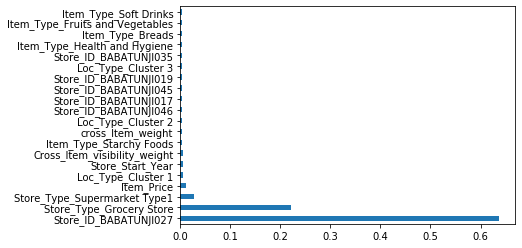

In [43]:
feat_import = pd.Series(xgb.feature_importances_, index = data.columns)
feat_import.sort_values(ascending = False).nlargest(20).plot(kind = 'barh')

In [44]:
# data2 = data.drop(['Item_ID', 'Item_Visibility'], axis = 1)

In [45]:
# test2 = test.drop(['Item_ID', 'Item_Visibility'], axis = 1)

In [46]:
final = xgb_test_pred/30

In [47]:
sub2 = pd.DataFrame(final, columns = ['Item_Store_Returns'])

In [48]:
sub2.head()

,Item_Store_Returns
0,1266.111306
1,8136.142692
2,8075.710124
3,1073.574373
4,7259.694206


In [49]:
sub2['Item_Store_Returns'] = round(sub2['Item_Store_Returns']).astype('int')

In [50]:
sub2.head()

,Item_Store_Returns
0,1266
1,8136
2,8076
3,1074
4,7260


In [51]:
submission = pd.concat([submit, sub2], axis = 1)

In [52]:
submission.head()

,Item_Store_ID,Item_Store_Returns
0,DRA59_BABATUNJI010,1266
1,DRA59_BABATUNJI013,8136
2,DRB01_BABATUNJI013,8076
3,DRB13_BABATUNJI010,1074
4,DRB13_BABATUNJI013,7260


In [53]:
submission.shape

(3532, 2)

In [54]:
submission.to_csv('My_submission2c2.csv', index = False)